In [40]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [41]:
in_dir = '../data/two_years_each/val_1/consistent'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

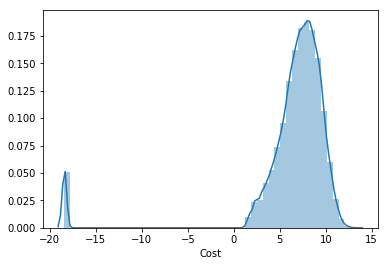

In [42]:
sns.distplot(np.log(df_train_Y['Cost'] + 0.00000001))
plt.plot()

In [43]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Cost']:
    df_train_Y['Cost_log'] = df_train_Y['Cost'].apply(log)
    df_val_Y['Cost_log'] = df_val_Y['Cost'].apply(log)

### データ構造転換

In [44]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Cost_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Cost_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [45]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=1000, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['Cost'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 1.0844124152930095e-05, 'colsample_bytree': 0.8, 'gamma': 6.488802219533368e-08, 'lambda': 8.030383949490836e-05, 'learning_rate': 0.35000000000000003, 'max_depth': 8, 'min_child_weight': 0.137828558537393, 'n_estimators': 273.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:5.55702	eval-rmse:5.40314                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.277	eval-rmse:4.02465                                                                                 

[2]	train-rmse:3.55814	eval-rmse:3.25585                                                                       

[24]	train-rmse:2.41443	eval-rmse:2.79243                                                                              

[25]	train-rmse:2.40077	eval-rmse:2.78562                                                                              

[26]	train-rmse:2.36854	eval-rmse:2.79458                                                                              

[27]	train-rmse:2.3457	eval-rmse:2.84682                                                                               

[28]	train-rmse:2.32065	eval-rmse:2.84975                                                                              

[29]	train-rmse:2.30736	eval-rmse:2.84881                                                                              

[30]	train-rmse:2.29445	eval-rmse:2.86028                                                                              

Stopping. Best iteration:                                                                                              
[10]	train-rmse:2.73429	eval-rmse

[52]	train-rmse:3.16283	eval-rmse:2.52616                                                                              

[53]	train-rmse:3.15599	eval-rmse:2.52062                                                                              

[54]	train-rmse:3.15045	eval-rmse:2.51527                                                                              

[55]	train-rmse:3.14558	eval-rmse:2.51007                                                                              

[56]	train-rmse:3.14042	eval-rmse:2.50571                                                                              

[57]	train-rmse:3.13562	eval-rmse:2.5019                                                                               

[58]	train-rmse:3.13065	eval-rmse:2.49883                                                                              

[59]	train-rmse:3.12593	eval-rmse:2.49572                                                                              

[60]	train-rmse:3.12094	eval-rms

[13]	train-rmse:3.19477	eval-rmse:2.48122                                                                              

[14]	train-rmse:3.18265	eval-rmse:2.4828                                                                               

[15]	train-rmse:3.17137	eval-rmse:2.47947                                                                              

[16]	train-rmse:3.16257	eval-rmse:2.48242                                                                              

[17]	train-rmse:3.15698	eval-rmse:2.48331                                                                              

[18]	train-rmse:3.15097	eval-rmse:2.48962                                                                              

[19]	train-rmse:3.14603	eval-rmse:2.48918                                                                              

[20]	train-rmse:3.13617	eval-rmse:2.48513                                                                              

[21]	train-rmse:3.12693	eval-rms

[30]	train-rmse:2.35505	eval-rmse:2.54358                                                                              

[31]	train-rmse:2.33479	eval-rmse:2.55191                                                                              

[32]	train-rmse:2.32233	eval-rmse:2.56163                                                                              

[33]	train-rmse:2.31665	eval-rmse:2.56155                                                                              

[34]	train-rmse:2.30459	eval-rmse:2.56458                                                                              

[35]	train-rmse:2.28952	eval-rmse:2.57245                                                                              

[36]	train-rmse:2.25784	eval-rmse:2.5704                                                                               

[37]	train-rmse:2.24995	eval-rmse:2.57557                                                                              

Stopping. Best iteration:       

[0]	train-rmse:5.92151	eval-rmse:5.7338                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.7661	eval-rmse:4.42164                                                                                

[2]	train-rmse:4.0665	eval-rmse:3.5984                                                                                 

[3]	train-rmse:3.66119	eval-rmse:3.10751                                                                               

[4]	train-rmse:3.43759	eval-rmse:2.82046                                                                               

[5]	train-rmse:3.30904	eval-rmse:2.66566                                                                               

[6]	train-rmse:3.23966	eval-rms

[22]	train-rmse:3.05915	eval-rmse:2.48715                                                                              

[23]	train-rmse:3.05064	eval-rmse:2.49795                                                                              

[24]	train-rmse:3.04418	eval-rmse:2.49379                                                                              

[25]	train-rmse:3.03663	eval-rmse:2.4945                                                                               

[26]	train-rmse:3.02778	eval-rmse:2.49607                                                                              

[27]	train-rmse:3.02421	eval-rmse:2.49445                                                                              

[28]	train-rmse:3.01392	eval-rmse:2.50105                                                                              

[29]	train-rmse:3.00598	eval-rmse:2.50481                                                                              

[30]	train-rmse:2.99925	eval-rms

[41]	train-rmse:2.9202	eval-rmse:2.47768                                                                               

[42]	train-rmse:2.9145	eval-rmse:2.47739                                                                               

[43]	train-rmse:2.90911	eval-rmse:2.47791                                                                              

[44]	train-rmse:2.90306	eval-rmse:2.47619                                                                              

[45]	train-rmse:2.89316	eval-rmse:2.4778                                                                               

[46]	train-rmse:2.88776	eval-rmse:2.47634                                                                              

[47]	train-rmse:2.88272	eval-rmse:2.47631                                                                              

[48]	train-rmse:2.87643	eval-rmse:2.4758                                                                               

[49]	train-rmse:2.86951	eval-rms

[29]	train-rmse:2.40724	eval-rmse:2.64564                                                                              

Stopping. Best iteration:                                                                                              
[9]	train-rmse:2.82048	eval-rmse:2.52175


loss: 72180501.45958517                                                                                                
Training with params:                                                                                                  
{'alpha': 1.461068748850531e-08, 'colsample_bytree': 0.9500000000000001, 'gamma': 6.535778327693953e-05, 'lambda': 2.774032170492528, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'min_child_weight': 0.34367946858167586, 'n_estimators': 524.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:6.6267	eval-rmse:6.54285                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be

[5]	train-rmse:3.2942	eval-rmse:2.55519                                                                                

[6]	train-rmse:3.25195	eval-rmse:2.51524                                                                               

[7]	train-rmse:3.2279	eval-rmse:2.49378                                                                                

[8]	train-rmse:3.20826	eval-rmse:2.49556                                                                               

[9]	train-rmse:3.19654	eval-rmse:2.48771                                                                               

[10]	train-rmse:3.18264	eval-rmse:2.4821                                                                               

[11]	train-rmse:3.17155	eval-rmse:2.48079                                                                              

[12]	train-rmse:3.15933	eval-rmse:2.48999                                                                              

[13]	train-rmse:3.15631	eval-rms

[33]	train-rmse:3.10738	eval-rmse:2.48016                                                                              

[34]	train-rmse:3.10549	eval-rmse:2.47924                                                                              

[35]	train-rmse:3.10084	eval-rmse:2.47669                                                                              

[36]	train-rmse:3.09818	eval-rmse:2.47351                                                                              

[37]	train-rmse:3.0942	eval-rmse:2.47482                                                                               

[38]	train-rmse:3.0896	eval-rmse:2.47947                                                                               

[39]	train-rmse:3.08624	eval-rmse:2.48411                                                                              

[40]	train-rmse:3.0835	eval-rmse:2.48321                                                                               

[41]	train-rmse:3.0789	eval-rmse

[43]	train-rmse:3.01407	eval-rmse:2.49424                                                                              

[44]	train-rmse:3.011	eval-rmse:2.49347                                                                                

[45]	train-rmse:3.00583	eval-rmse:2.49531                                                                              

[46]	train-rmse:3.00541	eval-rmse:2.49544                                                                              

Stopping. Best iteration:                                                                                              
[26]	train-rmse:3.09493	eval-rmse:2.4668


loss: 80024971.11686586                                                                                                
Training with params:                                                                                                  
{'alpha': 3.9890632364655563e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 7.646410354847015e-05, 'lambda

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.18892	eval-rmse:3.82535                                                                               

[2]	train-rmse:3.54805	eval-rmse:3.09177                                                                               

[3]	train-rmse:3.23051	eval-rmse:2.73675                                                                               

[4]	train-rmse:3.07034	eval-rmse:2.59785                                                                               

[5]	train-rmse:2.97841	eval-rmse:2.55249                                                                               

[6]	train-rmse:2.92173	eval-rmse:2.52688                                                                               

[7]	train-rmse:2.89058	eval-rmse:2.51013                                                                               

[8]	train-rmse:2.86686	eval-rmse

[31]	train-rmse:2.94484	eval-rmse:2.48348                                                                              

[32]	train-rmse:2.93868	eval-rmse:2.48153                                                                              

[33]	train-rmse:2.92658	eval-rmse:2.48397                                                                              

[34]	train-rmse:2.92165	eval-rmse:2.48154                                                                              

[35]	train-rmse:2.91412	eval-rmse:2.48273                                                                              

[36]	train-rmse:2.90982	eval-rmse:2.4818                                                                               

[37]	train-rmse:2.90268	eval-rmse:2.47807                                                                              

[38]	train-rmse:2.89631	eval-rmse:2.48089                                                                              

[39]	train-rmse:2.89046	eval-rms

[33]	train-rmse:3.18807	eval-rmse:2.48256                                                                              

[34]	train-rmse:3.18344	eval-rmse:2.47939                                                                              

[35]	train-rmse:3.17879	eval-rmse:2.47631                                                                              

[36]	train-rmse:3.17435	eval-rmse:2.47537                                                                              

[37]	train-rmse:3.16925	eval-rmse:2.47128                                                                              

[38]	train-rmse:3.16521	eval-rmse:2.46739                                                                              

[39]	train-rmse:3.1616	eval-rmse:2.46761                                                                               

[40]	train-rmse:3.15667	eval-rmse:2.46739                                                                              

[41]	train-rmse:3.15206	eval-rms

loss: 85390269.96450128                                                                                                
Training with params:                                                                                                  
{'alpha': 4.911734268026068e-07, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.1962451036883316e-05, 'lambda': 1.4578662640679396, 'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 5.4016600586199255, 'n_estimators': 677.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:5.41673	eval-rmse:5.11682                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.24618	eval-rmse:3.73294                                                                           

[16]	train-rmse:5.5788	eval-rmse:5.38709                                                                               

[17]	train-rmse:5.48306	eval-rmse:5.28285                                                                              

[18]	train-rmse:5.39007	eval-rmse:5.18135                                                                              

[19]	train-rmse:5.30046	eval-rmse:5.08327                                                                              

[20]	train-rmse:5.21378	eval-rmse:4.98797                                                                              

[21]	train-rmse:5.13018	eval-rmse:4.89572                                                                              

[22]	train-rmse:5.04854	eval-rmse:4.80627                                                                              

[23]	train-rmse:4.96979	eval-rmse:4.71941                                                                              

[24]	train-rmse:4.89345	eval-rms

[83]	train-rmse:3.03594	eval-rmse:2.62866                                                                              

[84]	train-rmse:3.02634	eval-rmse:2.621                                                                                

[85]	train-rmse:3.01738	eval-rmse:2.6138                                                                               

[86]	train-rmse:3.00921	eval-rmse:2.60703                                                                              

[87]	train-rmse:3.00172	eval-rmse:2.59991                                                                              

[88]	train-rmse:2.99346	eval-rmse:2.59359                                                                              

[89]	train-rmse:2.98634	eval-rmse:2.58786                                                                              

[90]	train-rmse:2.97812	eval-rmse:2.58147                                                                              

[91]	train-rmse:2.97122	eval-rms

[11]	train-rmse:2.45604	eval-rmse:2.67309                                                                              

[12]	train-rmse:2.41962	eval-rmse:2.69156                                                                              

[13]	train-rmse:2.3852	eval-rmse:2.7154                                                                                

[14]	train-rmse:2.3635	eval-rmse:2.71398                                                                               

[15]	train-rmse:2.32914	eval-rmse:2.73363                                                                              

[16]	train-rmse:2.29265	eval-rmse:2.76192                                                                              

[17]	train-rmse:2.25731	eval-rmse:2.77132                                                                              

[18]	train-rmse:2.21077	eval-rmse:2.79224                                                                              

[19]	train-rmse:2.1797	eval-rmse

[11]	train-rmse:2.54929	eval-rmse:2.66154                                                                              

[12]	train-rmse:2.50732	eval-rmse:2.68762                                                                              

[13]	train-rmse:2.48308	eval-rmse:2.69288                                                                              

[14]	train-rmse:2.46988	eval-rmse:2.69249                                                                              

[15]	train-rmse:2.4306	eval-rmse:2.69231                                                                               

[16]	train-rmse:2.4025	eval-rmse:2.69447                                                                               

[17]	train-rmse:2.38573	eval-rmse:2.71023                                                                              

[18]	train-rmse:2.36275	eval-rmse:2.71849                                                                              

[19]	train-rmse:2.32252	eval-rms

[12]	train-rmse:3.21335	eval-rmse:2.48886                                                                              

[13]	train-rmse:3.20763	eval-rmse:2.48322                                                                              

[14]	train-rmse:3.20451	eval-rmse:2.48805                                                                              

[15]	train-rmse:3.19863	eval-rmse:2.49223                                                                              

[16]	train-rmse:3.1908	eval-rmse:2.48645                                                                               

[17]	train-rmse:3.18458	eval-rmse:2.48508                                                                              

[18]	train-rmse:3.17916	eval-rmse:2.4826                                                                               

[19]	train-rmse:3.17381	eval-rmse:2.47978                                                                              

[20]	train-rmse:3.16894	eval-rms

[16]	train-rmse:2.32169	eval-rmse:2.71438                                                                              

[17]	train-rmse:2.28014	eval-rmse:2.72049                                                                              

[18]	train-rmse:2.26668	eval-rmse:2.71606                                                                              

[19]	train-rmse:2.25472	eval-rmse:2.71348                                                                              

[20]	train-rmse:2.21002	eval-rmse:2.73791                                                                              

[21]	train-rmse:2.18738	eval-rmse:2.75241                                                                              

[22]	train-rmse:2.16646	eval-rmse:2.75108                                                                              

[23]	train-rmse:2.13836	eval-rmse:2.76356                                                                              

[24]	train-rmse:2.10791	eval-rms

[15]	train-rmse:2.42976	eval-rmse:2.65151                                                                              

[16]	train-rmse:2.41011	eval-rmse:2.65458                                                                              

[17]	train-rmse:2.39266	eval-rmse:2.6616                                                                               

[18]	train-rmse:2.35819	eval-rmse:2.65537                                                                              

[19]	train-rmse:2.3151	eval-rmse:2.64503                                                                               

[20]	train-rmse:2.26902	eval-rmse:2.65058                                                                              

[21]	train-rmse:2.23648	eval-rmse:2.65367                                                                              

[22]	train-rmse:2.21633	eval-rmse:2.65087                                                                              

[23]	train-rmse:2.19983	eval-rms

[5]	train-rmse:2.75729	eval-rmse:2.70666                                                                               

[6]	train-rmse:2.63595	eval-rmse:2.63329                                                                               

[7]	train-rmse:2.55445	eval-rmse:2.61281                                                                               

[8]	train-rmse:2.49955	eval-rmse:2.60017                                                                               

[9]	train-rmse:2.4503	eval-rmse:2.60689                                                                                

[10]	train-rmse:2.42307	eval-rmse:2.60413                                                                              

[11]	train-rmse:2.39743	eval-rmse:2.6002                                                                               

[12]	train-rmse:2.37271	eval-rmse:2.596                                                                                

[13]	train-rmse:2.33188	eval-rms

Training with params:                                                                                                  
{'alpha': 0.0022805241211867762, 'colsample_bytree': 0.9500000000000001, 'gamma': 7.104323176035062e-07, 'lambda': 9.45474342816598, 'learning_rate': 0.325, 'max_depth': 9, 'min_child_weight': 0.10865837785351642, 'n_estimators': 246.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:5.72693	eval-rmse:5.56025                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.47114	eval-rmse:4.20844                                                                               

[2]	train-rmse:3.70977	eval-rmse:3.39737                                                           

[24]	train-rmse:2.09369	eval-rmse:2.56088                                                                              

[25]	train-rmse:2.07341	eval-rmse:2.56502                                                                              

[26]	train-rmse:2.06028	eval-rmse:2.56949                                                                              

[27]	train-rmse:2.04846	eval-rmse:2.56848                                                                              

[28]	train-rmse:2.03826	eval-rmse:2.56649                                                                              

[29]	train-rmse:2.01056	eval-rmse:2.56751                                                                              

[30]	train-rmse:2.00013	eval-rmse:2.56773                                                                              

[31]	train-rmse:1.97453	eval-rmse:2.56633                                                                              

[32]	train-rmse:1.9467	eval-rmse

{'alpha': 3.9083128213313784e-05, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.00016492935341849542, 'lambda': 0.02270286704237618, 'learning_rate': 0.275, 'max_depth': 6, 'min_child_weight': 0.40252097234386763, 'n_estimators': 245.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:6.05257	eval-rmse:5.8912                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.92859	eval-rmse:4.6221                                                                                

[2]	train-rmse:4.19423	eval-rmse:3.77505                                                                               

[3]	train-rmse:3.73592	eval-rmse:3.2348                                                      

[26]	train-rmse:2.09323	eval-rmse:2.76638                                                                              

[27]	train-rmse:2.06385	eval-rmse:2.81067                                                                              

Stopping. Best iteration:                                                                                              
[7]	train-rmse:2.62185	eval-rmse:2.58999


loss: 202568517.1165005                                                                                                
Training with params:                                                                                                  
{'alpha': 2.1951827670572636e-05, 'colsample_bytree': 0.9, 'gamma': 4.737807057278399e-07, 'lambda': 0.003893882433140298, 'learning_rate': 0.325, 'max_depth': 5, 'min_child_weight': 2.20860080157048, 'n_estimators': 464.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:5.78178	eval-rmse:5.55988                                

[15]	train-rmse:2.96711	eval-rmse:2.45818                                                                              

[16]	train-rmse:2.95257	eval-rmse:2.45724                                                                              

[17]	train-rmse:2.94355	eval-rmse:2.45549                                                                              

[18]	train-rmse:2.9281	eval-rmse:2.45079                                                                               

[19]	train-rmse:2.91331	eval-rmse:2.44549                                                                              

[20]	train-rmse:2.90499	eval-rmse:2.44774                                                                              

[21]	train-rmse:2.89363	eval-rmse:2.45008                                                                              

[22]	train-rmse:2.87798	eval-rmse:2.45734                                                                              

[23]	train-rmse:2.86899	eval-rms

[0]	train-rmse:5.99182	eval-rmse:5.8752                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.78533	eval-rmse:4.60403                                                                               

[2]	train-rmse:3.98325	eval-rmse:3.7582                                                                                

[3]	train-rmse:3.45814	eval-rmse:3.22637                                                                               

[4]	train-rmse:3.12473	eval-rmse:2.90819                                                                               

[5]	train-rmse:2.89844	eval-rmse:2.72917                                                                               

[6]	train-rmse:2.74141	eval-rms

[19]	train-rmse:3.20661	eval-rmse:2.46345                                                                              

[20]	train-rmse:3.20088	eval-rmse:2.46291                                                                              

[21]	train-rmse:3.19841	eval-rmse:2.46288                                                                              

[22]	train-rmse:3.19567	eval-rmse:2.46286                                                                              

[23]	train-rmse:3.19207	eval-rmse:2.46362                                                                              

[24]	train-rmse:3.18946	eval-rmse:2.46353                                                                              

[25]	train-rmse:3.18448	eval-rmse:2.45757                                                                              

[26]	train-rmse:3.17847	eval-rmse:2.45589                                                                              

[27]	train-rmse:3.17373	eval-rms

[5]	train-rmse:2.99257	eval-rmse:2.62633                                                                               

[6]	train-rmse:2.94449	eval-rmse:2.60767                                                                               

[7]	train-rmse:2.91347	eval-rmse:2.59936                                                                               

[8]	train-rmse:2.88644	eval-rmse:2.60042                                                                               

[9]	train-rmse:2.86105	eval-rmse:2.61654                                                                               

[10]	train-rmse:2.83411	eval-rmse:2.61925                                                                              

[11]	train-rmse:2.80005	eval-rmse:2.62176                                                                              

[12]	train-rmse:2.77495	eval-rmse:2.64741                                                                              

[13]	train-rmse:2.75493	eval-rms


loss: 70028962.51772986                                                                                                
Training with params:                                                                                                  
{'alpha': 1.013862458077003e-06, 'colsample_bytree': 0.9, 'gamma': 4.101201524713412e-05, 'lambda': 0.03548593098304714, 'learning_rate': 0.30000000000000004, 'max_depth': 5, 'min_child_weight': 0.1730799259029148, 'n_estimators': 572.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:5.92145	eval-rmse:5.71954                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.76627	eval-rmse:4.40141                                                                         

[21]	train-rmse:2.43908	eval-rmse:2.43708                                                                              

[22]	train-rmse:2.41724	eval-rmse:2.43803                                                                              

[23]	train-rmse:2.39856	eval-rmse:2.43274                                                                              

[24]	train-rmse:2.386	eval-rmse:2.43376                                                                                

[25]	train-rmse:2.37785	eval-rmse:2.43607                                                                              

[26]	train-rmse:2.35009	eval-rmse:2.44451                                                                              

[27]	train-rmse:2.32931	eval-rmse:2.44864                                                                              

[28]	train-rmse:2.30177	eval-rmse:2.43654                                                                              

[29]	train-rmse:2.28088	eval-rms

Training with params:                                                                                                  
{'alpha': 3.442036976977299e-05, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.038092199797426396, 'lambda': 1.136416194557436, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'min_child_weight': 0.4997612978958308, 'n_estimators': 442.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:7.27585	eval-rmse:7.21692                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.84306	eval-rmse:6.74938                                                                               

[2]	train-rmse:6.44925	eval-rmse:6.32024                                                             

[62]	train-rmse:2.88241	eval-rmse:2.4792                                                                               

[63]	train-rmse:2.87798	eval-rmse:2.48076                                                                              

[64]	train-rmse:2.87501	eval-rmse:2.48223                                                                              

[65]	train-rmse:2.87112	eval-rmse:2.48408                                                                              

[66]	train-rmse:2.86769	eval-rmse:2.48626                                                                              

[67]	train-rmse:2.86153	eval-rmse:2.48387                                                                              

[68]	train-rmse:2.85853	eval-rmse:2.48443                                                                              

Stopping. Best iteration:                                                                                              
[48]	train-rmse:2.94861	eval-rmse

[17]	train-rmse:2.77347	eval-rmse:2.52344                                                                              

[18]	train-rmse:2.74595	eval-rmse:2.52827                                                                              

[19]	train-rmse:2.72562	eval-rmse:2.54089                                                                              

[20]	train-rmse:2.71403	eval-rmse:2.54341                                                                              

[21]	train-rmse:2.68706	eval-rmse:2.5453                                                                               

[22]	train-rmse:2.66507	eval-rmse:2.54255                                                                              

[23]	train-rmse:2.64736	eval-rmse:2.54031                                                                              

[24]	train-rmse:2.64308	eval-rmse:2.54041                                                                              

[25]	train-rmse:2.62841	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.83746	eval-rmse:3.5458                                                                                

[2]	train-rmse:3.25228	eval-rmse:2.93068                                                                               

[3]	train-rmse:2.99051	eval-rmse:2.70473                                                                               

[4]	train-rmse:2.84238	eval-rmse:2.64996                                                                               

[5]	train-rmse:2.77809	eval-rmse:2.63026                                                                               

[6]	train-rmse:2.74508	eval-rmse:2.62629                                                                               

[7]	train-rmse:2.66864	eval-rms

[31]	train-rmse:2.09842	eval-rmse:2.55381                                                                              

[32]	train-rmse:2.07659	eval-rmse:2.56742                                                                              

[33]	train-rmse:2.06538	eval-rmse:2.56344                                                                              

[34]	train-rmse:2.05414	eval-rmse:2.55943                                                                              

[35]	train-rmse:2.03916	eval-rmse:2.56479                                                                              

[36]	train-rmse:2.0266	eval-rmse:2.56558                                                                               

[37]	train-rmse:2.00563	eval-rmse:2.5585                                                                               

[38]	train-rmse:1.99087	eval-rmse:2.55659                                                                              

[39]	train-rmse:1.98068	eval-rms

[46]	train-rmse:3.08308	eval-rmse:2.48022                                                                              

[47]	train-rmse:3.08051	eval-rmse:2.48108                                                                              

[48]	train-rmse:3.07836	eval-rmse:2.4805                                                                               

[49]	train-rmse:3.0752	eval-rmse:2.47919                                                                               

[50]	train-rmse:3.07299	eval-rmse:2.48291                                                                              

[51]	train-rmse:3.07044	eval-rmse:2.48114                                                                              

Stopping. Best iteration:                                                                                              
[31]	train-rmse:3.13599	eval-rmse:2.45572


loss: 85971986.36077732                                                                                       

[20]	train-rmse:2.84205	eval-rmse:2.46887                                                                              

[21]	train-rmse:2.82674	eval-rmse:2.4665                                                                               

[22]	train-rmse:2.80809	eval-rmse:2.46646                                                                              

[23]	train-rmse:2.79375	eval-rmse:2.47161                                                                              

[24]	train-rmse:2.78107	eval-rmse:2.4722                                                                               

[25]	train-rmse:2.76836	eval-rmse:2.47                                                                                 

[26]	train-rmse:2.75971	eval-rmse:2.4684                                                                               

[27]	train-rmse:2.74991	eval-rmse:2.47027                                                                              

[28]	train-rmse:2.73146	eval-rms

[3]	train-rmse:3.61525	eval-rmse:3.08312                                                                               

[4]	train-rmse:3.3752	eval-rmse:2.79889                                                                                

[5]	train-rmse:3.24085	eval-rmse:2.64885                                                                               

[6]	train-rmse:3.15829	eval-rmse:2.57814                                                                               

[7]	train-rmse:3.11078	eval-rmse:2.53551                                                                               

[8]	train-rmse:3.07422	eval-rmse:2.51138                                                                               

[9]	train-rmse:3.05205	eval-rmse:2.50008                                                                               

[10]	train-rmse:3.02432	eval-rmse:2.50618                                                                              

[11]	train-rmse:3.00714	eval-rms

[33]	train-rmse:3.10562	eval-rmse:2.46665                                                                              

[34]	train-rmse:3.09947	eval-rmse:2.46413                                                                              

[35]	train-rmse:3.09746	eval-rmse:2.46666                                                                              

[36]	train-rmse:3.09395	eval-rmse:2.47068                                                                              

[37]	train-rmse:3.08971	eval-rmse:2.47619                                                                              

[38]	train-rmse:3.0852	eval-rmse:2.47137                                                                               

[39]	train-rmse:3.08009	eval-rmse:2.46928                                                                              

[40]	train-rmse:3.07729	eval-rmse:2.46937                                                                              

[41]	train-rmse:3.07653	eval-rms

[10]	train-rmse:2.72145	eval-rmse:2.57213                                                                              

[11]	train-rmse:2.70071	eval-rmse:2.56696                                                                              

[12]	train-rmse:2.66875	eval-rmse:2.5656                                                                               

[13]	train-rmse:2.63894	eval-rmse:2.56816                                                                              

[14]	train-rmse:2.60735	eval-rmse:2.56442                                                                              

[15]	train-rmse:2.58242	eval-rmse:2.56777                                                                              

[16]	train-rmse:2.56831	eval-rmse:2.56726                                                                              

[17]	train-rmse:2.55425	eval-rmse:2.5666                                                                               

[18]	train-rmse:2.53439	eval-rms

[34]	train-rmse:3.12104	eval-rmse:2.48072                                                                              

[35]	train-rmse:3.11978	eval-rmse:2.47929                                                                              

[36]	train-rmse:3.11725	eval-rmse:2.47961                                                                              

[37]	train-rmse:3.11252	eval-rmse:2.47901                                                                              

[38]	train-rmse:3.11056	eval-rmse:2.48003                                                                              

[39]	train-rmse:3.10615	eval-rmse:2.47364                                                                              

[40]	train-rmse:3.10321	eval-rmse:2.47375                                                                              

[41]	train-rmse:3.1006	eval-rmse:2.4761                                                                                

[42]	train-rmse:3.09844	eval-rms

[23]	train-rmse:2.05132	eval-rmse:2.74476                                                                              

[24]	train-rmse:2.0289	eval-rmse:2.75481                                                                               

[25]	train-rmse:1.99879	eval-rmse:2.7563                                                                               

[26]	train-rmse:1.96229	eval-rmse:2.76587                                                                              

[27]	train-rmse:1.909	eval-rmse:2.76847                                                                                

[28]	train-rmse:1.88057	eval-rmse:2.79256                                                                              

[29]	train-rmse:1.85394	eval-rmse:2.79318                                                                              

[30]	train-rmse:1.84121	eval-rmse:2.79607                                                                              

Stopping. Best iteration:       

[51]	train-rmse:2.69487	eval-rmse:2.54638                                                                              

[52]	train-rmse:2.68078	eval-rmse:2.54033                                                                              

[53]	train-rmse:2.67134	eval-rmse:2.53688                                                                              

[54]	train-rmse:2.6594	eval-rmse:2.53315                                                                               

[55]	train-rmse:2.6503	eval-rmse:2.52949                                                                               

[56]	train-rmse:2.64048	eval-rmse:2.52492                                                                              

[57]	train-rmse:2.63029	eval-rmse:2.52209                                                                              

[58]	train-rmse:2.62226	eval-rmse:2.51801                                                                              

[59]	train-rmse:2.61362	eval-rms

[17]	train-rmse:2.61187	eval-rmse:2.63274                                                                              

[18]	train-rmse:2.59815	eval-rmse:2.63435                                                                              

[19]	train-rmse:2.57791	eval-rmse:2.64002                                                                              

[20]	train-rmse:2.55314	eval-rmse:2.6643                                                                               

[21]	train-rmse:2.53078	eval-rmse:2.6629                                                                               

[22]	train-rmse:2.50258	eval-rmse:2.66414                                                                              

[23]	train-rmse:2.48126	eval-rmse:2.68164                                                                              

[24]	train-rmse:2.45869	eval-rmse:2.6888                                                                               

[25]	train-rmse:2.43615	eval-rms

[49]	train-rmse:2.05556	eval-rmse:2.51151                                                                              

[50]	train-rmse:2.03723	eval-rmse:2.51344                                                                              

[51]	train-rmse:2.02759	eval-rmse:2.512                                                                                

Stopping. Best iteration:                                                                                              
[31]	train-rmse:2.27101	eval-rmse:2.50015


loss: 65399528.677567765                                                                                               
Training with params:                                                                                                  
{'alpha': 2.166939833351998e-05, 'colsample_bytree': 0.9, 'gamma': 0.0012977055137883288, 'lambda': 0.04606678174568414, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'min_child_weight': 2.426942898092422, 'n_estimators': 856

[7]	train-rmse:2.81561	eval-rmse:2.71327                                                                               

[8]	train-rmse:2.71415	eval-rmse:2.64593                                                                               

[9]	train-rmse:2.64092	eval-rmse:2.60403                                                                               

[10]	train-rmse:2.56972	eval-rmse:2.58471                                                                              

[11]	train-rmse:2.51302	eval-rmse:2.57688                                                                              

[12]	train-rmse:2.47502	eval-rmse:2.57711                                                                              

[13]	train-rmse:2.43262	eval-rmse:2.57158                                                                              

[14]	train-rmse:2.40836	eval-rmse:2.57515                                                                              

[15]	train-rmse:2.37299	eval-rms

[33]	train-rmse:1.97902	eval-rmse:2.52945                                                                              

[34]	train-rmse:1.9524	eval-rmse:2.53383                                                                               

[35]	train-rmse:1.93194	eval-rmse:2.53698                                                                              

[36]	train-rmse:1.91268	eval-rmse:2.53257                                                                              

[37]	train-rmse:1.89667	eval-rmse:2.52785                                                                              

[38]	train-rmse:1.89139	eval-rmse:2.5297                                                                               

[39]	train-rmse:1.88167	eval-rmse:2.52756                                                                              

Stopping. Best iteration:                                                                                              
[19]	train-rmse:2.26212	eval-rmse

[12]	train-rmse:2.98028	eval-rmse:2.8288                                                                               

[13]	train-rmse:2.89271	eval-rmse:2.7538                                                                               

[14]	train-rmse:2.81696	eval-rmse:2.69592                                                                              

[15]	train-rmse:2.75417	eval-rmse:2.65188                                                                              

[16]	train-rmse:2.69819	eval-rmse:2.61711                                                                              

[17]	train-rmse:2.65005	eval-rmse:2.58607                                                                              

[18]	train-rmse:2.60704	eval-rmse:2.5672                                                                               

[19]	train-rmse:2.56789	eval-rmse:2.55401                                                                              

[20]	train-rmse:2.53526	eval-rms

[13]	train-rmse:3.06757	eval-rmse:2.50643                                                                              

[14]	train-rmse:3.05931	eval-rmse:2.50855                                                                              

[15]	train-rmse:3.04565	eval-rmse:2.50632                                                                              

[16]	train-rmse:3.03594	eval-rmse:2.50644                                                                              

[17]	train-rmse:3.02347	eval-rmse:2.5078                                                                               

[18]	train-rmse:3.01026	eval-rmse:2.50999                                                                              

[19]	train-rmse:2.99845	eval-rmse:2.50382                                                                              

[20]	train-rmse:2.98771	eval-rmse:2.49394                                                                              

[21]	train-rmse:2.97348	eval-rms

[29]	train-rmse:2.846	eval-rmse:2.51518                                                                                

[30]	train-rmse:2.83725	eval-rmse:2.51758                                                                              

[31]	train-rmse:2.83129	eval-rmse:2.51897                                                                              

[32]	train-rmse:2.82516	eval-rmse:2.52075                                                                              

[33]	train-rmse:2.81455	eval-rmse:2.51845                                                                              

[34]	train-rmse:2.80103	eval-rmse:2.51782                                                                              

[35]	train-rmse:2.79166	eval-rmse:2.51989                                                                              

[36]	train-rmse:2.78452	eval-rmse:2.51977                                                                              

[37]	train-rmse:2.77517	eval-rms

[9]	train-rmse:2.88401	eval-rmse:2.65191                                                                               

[10]	train-rmse:2.81438	eval-rmse:2.60961                                                                              

[11]	train-rmse:2.75614	eval-rmse:2.57312                                                                              

[12]	train-rmse:2.713	eval-rmse:2.55591                                                                                

[13]	train-rmse:2.67618	eval-rmse:2.54162                                                                              

[14]	train-rmse:2.64716	eval-rmse:2.53093                                                                              

[15]	train-rmse:2.61649	eval-rmse:2.5233                                                                               

[16]	train-rmse:2.5876	eval-rmse:2.52909                                                                               

[17]	train-rmse:2.56387	eval-rms

[33]	train-rmse:3.18642	eval-rmse:2.48657                                                                              

[34]	train-rmse:3.18165	eval-rmse:2.48377                                                                              

[35]	train-rmse:3.17783	eval-rmse:2.48199                                                                              

[36]	train-rmse:3.17347	eval-rmse:2.4812                                                                               

[37]	train-rmse:3.1675	eval-rmse:2.4805                                                                                

[38]	train-rmse:3.16186	eval-rmse:2.48668                                                                              

[39]	train-rmse:3.15792	eval-rmse:2.48576                                                                              

[40]	train-rmse:3.15391	eval-rmse:2.4837                                                                               

[41]	train-rmse:3.15031	eval-rms

[16]	train-rmse:2.19676	eval-rmse:2.66059                                                                              

[17]	train-rmse:2.16719	eval-rmse:2.66547                                                                              

[18]	train-rmse:2.12372	eval-rmse:2.65255                                                                              

[19]	train-rmse:2.09667	eval-rmse:2.65754                                                                              

[20]	train-rmse:2.05437	eval-rmse:2.66787                                                                              

[21]	train-rmse:2.02542	eval-rmse:2.67571                                                                              

[22]	train-rmse:2.00393	eval-rmse:2.68257                                                                              

[23]	train-rmse:1.9534	eval-rmse:2.67957                                                                               

[24]	train-rmse:1.92204	eval-rms

[43]	train-rmse:3.09644	eval-rmse:2.4803                                                                               

[44]	train-rmse:3.09329	eval-rmse:2.48188                                                                              

[45]	train-rmse:3.0893	eval-rmse:2.4794                                                                                

[46]	train-rmse:3.08695	eval-rmse:2.48031                                                                              

[47]	train-rmse:3.08421	eval-rmse:2.48183                                                                              

[48]	train-rmse:3.08079	eval-rmse:2.4865                                                                               

[49]	train-rmse:3.07924	eval-rmse:2.48602                                                                              

[50]	train-rmse:3.07647	eval-rmse:2.4856                                                                               

[51]	train-rmse:3.07163	eval-rms

[0]	train-rmse:5.0002	eval-rmse:4.75704                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.73545	eval-rmse:3.3732                                                                                

[2]	train-rmse:3.19946	eval-rmse:2.82342                                                                               

[3]	train-rmse:2.97523	eval-rmse:2.61904                                                                               

[4]	train-rmse:2.85798	eval-rmse:2.5567                                                                                

[5]	train-rmse:2.79065	eval-rmse:2.53187                                                                               

[6]	train-rmse:2.74966	eval-rms

[31]	train-rmse:2.1397	eval-rmse:2.6341                                                                                

[32]	train-rmse:2.13039	eval-rmse:2.637                                                                                

[33]	train-rmse:2.11359	eval-rmse:2.63347                                                                              

[34]	train-rmse:2.10755	eval-rmse:2.63376                                                                              

Stopping. Best iteration:                                                                                              
[14]	train-rmse:2.49209	eval-rmse:2.55663


loss: 69536528.2769285                                                                                                 
Training with params:                                                                                                  
{'alpha': 0.0002938013791422319, 'colsample_bytree': 0.9, 'gamma': 5.358666455954731e-07, 'lambda': 1.9961212576

[16]	train-rmse:2.46559	eval-rmse:2.61543                                                                              

[17]	train-rmse:2.43085	eval-rmse:2.62432                                                                              

[18]	train-rmse:2.39709	eval-rmse:2.63744                                                                              

[19]	train-rmse:2.36936	eval-rmse:2.62779                                                                              

[20]	train-rmse:2.34927	eval-rmse:2.63987                                                                              

[21]	train-rmse:2.32613	eval-rmse:2.64244                                                                              

[22]	train-rmse:2.30258	eval-rmse:2.64896                                                                              

[23]	train-rmse:2.27982	eval-rmse:2.65416                                                                              

[24]	train-rmse:2.26259	eval-rms

[18]	train-rmse:2.27029	eval-rmse:2.74246                                                                              

[19]	train-rmse:2.24005	eval-rmse:2.74276                                                                              

[20]	train-rmse:2.22303	eval-rmse:2.74667                                                                              

[21]	train-rmse:2.1917	eval-rmse:2.74782                                                                               

[22]	train-rmse:2.17363	eval-rmse:2.76237                                                                              

[23]	train-rmse:2.13901	eval-rmse:2.78244                                                                              

[24]	train-rmse:2.08465	eval-rmse:2.78298                                                                              

[25]	train-rmse:2.07512	eval-rmse:2.78122                                                                              

[26]	train-rmse:2.03455	eval-rms

[16]	train-rmse:2.60938	eval-rmse:2.51559                                                                              

[17]	train-rmse:2.59351	eval-rmse:2.51881                                                                              

[18]	train-rmse:2.5877	eval-rmse:2.51576                                                                               

[19]	train-rmse:2.5596	eval-rmse:2.51728                                                                               

[20]	train-rmse:2.54008	eval-rmse:2.51645                                                                              

[21]	train-rmse:2.52877	eval-rmse:2.52272                                                                              

[22]	train-rmse:2.49864	eval-rmse:2.54713                                                                              

[23]	train-rmse:2.48434	eval-rmse:2.54352                                                                              

[24]	train-rmse:2.46957	eval-rms

[10]	train-rmse:3.00579	eval-rmse:2.50927                                                                              

[11]	train-rmse:2.98885	eval-rmse:2.50774                                                                              

[12]	train-rmse:2.97069	eval-rmse:2.51561                                                                              

[13]	train-rmse:2.95697	eval-rmse:2.51731                                                                              

[14]	train-rmse:2.94192	eval-rmse:2.52183                                                                              

[15]	train-rmse:2.92092	eval-rmse:2.52261                                                                              

[16]	train-rmse:2.90855	eval-rmse:2.52071                                                                              

[17]	train-rmse:2.89775	eval-rmse:2.51008                                                                              

[18]	train-rmse:2.88303	eval-rms

[0]	train-rmse:5.71709	eval-rmse:5.55656                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.45941	eval-rmse:4.19097                                                                               

[2]	train-rmse:3.72812	eval-rmse:3.38169                                                                               

[3]	train-rmse:3.30784	eval-rmse:2.92289                                                                               

[4]	train-rmse:3.06353	eval-rmse:2.7015                                                                                

[5]	train-rmse:2.92596	eval-rmse:2.6048                                                                                

[6]	train-rmse:2.82587	eval-rms

Training with params:                                                                                                  
{'alpha': 2.0008178253504736e-05, 'colsample_bytree': 0.9, 'gamma': 8.052002351521948e-06, 'lambda': 0.00014389497101408635, 'learning_rate': 0.42500000000000004, 'max_depth': 3, 'min_child_weight': 0.7504428161814689, 'n_estimators': 412.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:5.27717	eval-rmse:4.95947                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.12097	eval-rmse:3.56092                                                                               

[2]	train-rmse:3.629	eval-rmse:2.93819                                                        

[23]	train-rmse:2.47673	eval-rmse:2.69622                                                                              

[24]	train-rmse:2.45752	eval-rmse:2.73413                                                                              

[25]	train-rmse:2.44027	eval-rmse:2.73359                                                                              

[26]	train-rmse:2.43297	eval-rmse:2.73606                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:2.91174	eval-rmse:2.57193


loss: 65364100.95400972                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0017118639676647186, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.4750646835799086e-05, 'lambda

[8]	train-rmse:3.0816	eval-rmse:2.56246                                                                                

[9]	train-rmse:3.05121	eval-rmse:2.54049                                                                               

[10]	train-rmse:3.01754	eval-rmse:2.53689                                                                              

[11]	train-rmse:2.99984	eval-rmse:2.52851                                                                              

[12]	train-rmse:2.9853	eval-rmse:2.52535                                                                               

[13]	train-rmse:2.96281	eval-rmse:2.54502                                                                              

[14]	train-rmse:2.94736	eval-rmse:2.54118                                                                              

[15]	train-rmse:2.92611	eval-rmse:2.55004                                                                              

[16]	train-rmse:2.91454	eval-rms

[0]	train-rmse:5.79615	eval-rmse:5.56212                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.62887	eval-rmse:4.21916                                                                               

[2]	train-rmse:3.96591	eval-rmse:3.41464                                                                               

[3]	train-rmse:3.61048	eval-rmse:2.96203                                                                               

[4]	train-rmse:3.42436	eval-rmse:2.72302                                                                               

[5]	train-rmse:3.32717	eval-rmse:2.60247                                                                               

[6]	train-rmse:3.27178	eval-rms

loss: 125490903.99720395                                                                                               
Training with params:                                                                                                  
{'alpha': 2.6455733907879215e-05, 'colsample_bytree': 0.9, 'gamma': 0.0001320022675154527, 'lambda': 0.08009148786654625, 'learning_rate': 0.30000000000000004, 'max_depth': 3, 'min_child_weight': 0.5384309590685804, 'n_estimators': 361.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:5.96238	eval-rmse:5.73572                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.84061	eval-rmse:4.42921                                                          

[17]	train-rmse:2.33835	eval-rmse:2.64735                                                                              

[18]	train-rmse:2.31063	eval-rmse:2.67502                                                                              

[19]	train-rmse:2.29203	eval-rmse:2.681                                                                                

[20]	train-rmse:2.26111	eval-rmse:2.68347                                                                              

[21]	train-rmse:2.23089	eval-rmse:2.6926                                                                               

[22]	train-rmse:2.19713	eval-rmse:2.677                                                                                

[23]	train-rmse:2.16439	eval-rmse:2.67609                                                                              

[24]	train-rmse:2.14367	eval-rmse:2.67347                                                                              

[25]	train-rmse:2.13166	eval-rms

[12]	train-rmse:3.10287	eval-rmse:2.52782                                                                              

[13]	train-rmse:3.08816	eval-rmse:2.52239                                                                              

[14]	train-rmse:3.0723	eval-rmse:2.52106                                                                               

[15]	train-rmse:3.06097	eval-rmse:2.51783                                                                              

[16]	train-rmse:3.0447	eval-rmse:2.51206                                                                               

[17]	train-rmse:3.03534	eval-rmse:2.50597                                                                              

[18]	train-rmse:3.02543	eval-rmse:2.5057                                                                               

[19]	train-rmse:3.02009	eval-rmse:2.50911                                                                              

[20]	train-rmse:3.00676	eval-rms

[0]	train-rmse:5.58648	eval-rmse:5.39921                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.31335	eval-rmse:4.01497                                                                               

[2]	train-rmse:3.60822	eval-rmse:3.24389                                                                               

[3]	train-rmse:3.23076	eval-rmse:2.86631                                                                               

[4]	train-rmse:3.00961	eval-rmse:2.66441                                                                               

[5]	train-rmse:2.87549	eval-rmse:2.57534                                                                               

[6]	train-rmse:2.80052	eval-rms

[28]	train-rmse:3.06856	eval-rmse:2.45873                                                                              

[29]	train-rmse:3.05979	eval-rmse:2.45894                                                                              

[30]	train-rmse:3.05628	eval-rmse:2.45704                                                                              

[31]	train-rmse:3.05084	eval-rmse:2.46437                                                                              

[32]	train-rmse:3.04995	eval-rmse:2.46338                                                                              

[33]	train-rmse:3.04478	eval-rmse:2.46287                                                                              

[34]	train-rmse:3.04079	eval-rmse:2.46205                                                                              

[35]	train-rmse:3.03404	eval-rmse:2.46101                                                                              

[36]	train-rmse:3.02887	eval-rms

[0]	train-rmse:5.27698	eval-rmse:4.95759                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.1192	eval-rmse:3.55258                                                                                

[2]	train-rmse:3.62788	eval-rmse:2.93857                                                                               

[3]	train-rmse:3.43635	eval-rmse:2.69607                                                                               

[4]	train-rmse:3.35431	eval-rmse:2.58588                                                                               

[5]	train-rmse:3.31464	eval-rmse:2.54949                                                                               

[6]	train-rmse:3.29171	eval-rms

[10]	train-rmse:2.59175	eval-rmse:2.59112                                                                              

[11]	train-rmse:2.55839	eval-rmse:2.60624                                                                              

[12]	train-rmse:2.52394	eval-rmse:2.62164                                                                              

[13]	train-rmse:2.5019	eval-rmse:2.63052                                                                               

[14]	train-rmse:2.48896	eval-rmse:2.63363                                                                              

[15]	train-rmse:2.45321	eval-rmse:2.6513                                                                               

[16]	train-rmse:2.41968	eval-rmse:2.65871                                                                              

[17]	train-rmse:2.41263	eval-rmse:2.66038                                                                              

[18]	train-rmse:2.35608	eval-rms

[5]	train-rmse:3.20158	eval-rmse:2.71789                                                                               

[6]	train-rmse:3.08897	eval-rmse:2.61102                                                                               

[7]	train-rmse:3.00987	eval-rmse:2.55122                                                                               

[8]	train-rmse:2.95714	eval-rmse:2.52186                                                                               

[9]	train-rmse:2.91716	eval-rmse:2.51117                                                                               

[10]	train-rmse:2.89136	eval-rmse:2.50457                                                                              

[11]	train-rmse:2.86842	eval-rmse:2.49809                                                                              

[12]	train-rmse:2.84453	eval-rmse:2.50102                                                                              

[13]	train-rmse:2.82421	eval-rms

{'alpha': 0.00024966935259043444, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.004386494645616856, 'lambda': 1.1638661443188698, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'min_child_weight': 1.360154633977799, 'n_estimators': 255.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:6.81694	eval-rmse:6.72077                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.05804	eval-rmse:5.88042                                                                               

[2]	train-rmse:5.43309	eval-rmse:5.18036                                                                               

[3]	train-rmse:4.92922	eval-rmse:4.60485                                            

[63]	train-rmse:2.9029	eval-rmse:2.47447                                                                               

[64]	train-rmse:2.90094	eval-rmse:2.47478                                                                              

[65]	train-rmse:2.89859	eval-rmse:2.47491                                                                              

[66]	train-rmse:2.89468	eval-rmse:2.47525                                                                              

[67]	train-rmse:2.89347	eval-rmse:2.47494                                                                              

[68]	train-rmse:2.89001	eval-rmse:2.47646                                                                              

[69]	train-rmse:2.88594	eval-rmse:2.47562                                                                              

[70]	train-rmse:2.88209	eval-rmse:2.47839                                                                              

[71]	train-rmse:2.87807	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.04573	eval-rmse:3.82161                                                                               

[2]	train-rmse:3.32441	eval-rmse:3.11668                                                                               

[3]	train-rmse:2.95154	eval-rmse:2.79291                                                                               

[4]	train-rmse:2.74169	eval-rmse:2.66074                                                                               

[5]	train-rmse:2.60229	eval-rmse:2.63175                                                                               

[6]	train-rmse:2.49053	eval-rmse:2.65354                                                                               

[7]	train-rmse:2.4415	eval-rmse:2.65084                                                                                

[8]	train-rmse:2.37156	eval-rmse


loss: 61688196.60372104                                                                                                
Training with params:                                                                                                  
{'alpha': 0.3138157355562787, 'colsample_bytree': 0.9500000000000001, 'gamma': 9.87562027435791e-06, 'lambda': 6.102932745858477e-06, 'learning_rate': 0.42500000000000004, 'max_depth': 4, 'min_child_weight': 0.9970038472321346, 'n_estimators': 379.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:5.24553	eval-rmse:4.93365                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.06909	eval-rmse:3.5223                                                             

[23]	train-rmse:3.21582	eval-rmse:2.50454                                                                              

[24]	train-rmse:3.21248	eval-rmse:2.50146                                                                              

[25]	train-rmse:3.20986	eval-rmse:2.50172                                                                              

[26]	train-rmse:3.20076	eval-rmse:2.49648                                                                              

[27]	train-rmse:3.19668	eval-rmse:2.49361                                                                              

[28]	train-rmse:3.19276	eval-rmse:2.48968                                                                              

[29]	train-rmse:3.18951	eval-rmse:2.48481                                                                              

[30]	train-rmse:3.18477	eval-rmse:2.48794                                                                              

[31]	train-rmse:3.18188	eval-rms

[90]	train-rmse:3.05389	eval-rmse:2.47455                                                                              

[91]	train-rmse:3.0524	eval-rmse:2.47506                                                                               

[92]	train-rmse:3.05109	eval-rmse:2.47505                                                                              

Stopping. Best iteration:                                                                                              
[72]	train-rmse:3.0879	eval-rmse:2.47022


loss: 82598673.73732479                                                                                                
Training with params:                                                                                                  
{'alpha': 1.9827572336750697e-06, 'colsample_bytree': 0.9500000000000001, 'gamma': 1.9184212142976157e-05, 'lambda': 5.963393348191345, 'learning_rate': 0.47500000000000003, 'max_depth': 8, 'min_child_weight': 0.6818452342012203, 'n_e

[24]	train-rmse:1.83396	eval-rmse:2.84025                                                                              

[25]	train-rmse:1.78811	eval-rmse:2.87047                                                                              

[26]	train-rmse:1.76352	eval-rmse:2.86989                                                                              

[27]	train-rmse:1.73104	eval-rmse:2.87121                                                                              

Stopping. Best iteration:                                                                                              
[7]	train-rmse:2.39006	eval-rmse:2.71592


loss: 797147604.0148519                                                                                                
Training with params:                                                                                                  
{'alpha': 1.3467051063167578e-06, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.000903786041701846, 'lambda'

[17]	train-rmse:5.483	eval-rmse:5.28507                                                                                

[18]	train-rmse:5.38964	eval-rmse:5.18403                                                                              

[19]	train-rmse:5.3002	eval-rmse:5.08501                                                                               

[20]	train-rmse:5.2131	eval-rmse:4.98941                                                                               

[21]	train-rmse:5.12955	eval-rmse:4.89792                                                                              

[22]	train-rmse:5.04813	eval-rmse:4.80858                                                                              

[23]	train-rmse:4.96963	eval-rmse:4.72219                                                                              

[24]	train-rmse:4.89286	eval-rmse:4.63759                                                                              

[25]	train-rmse:4.81945	eval-rms

[84]	train-rmse:3.0292	eval-rmse:2.62745                                                                               

[85]	train-rmse:3.02117	eval-rmse:2.62068                                                                              

[86]	train-rmse:3.01315	eval-rmse:2.61407                                                                              

[87]	train-rmse:3.00526	eval-rmse:2.60761                                                                              

[88]	train-rmse:2.99661	eval-rmse:2.60107                                                                              

[89]	train-rmse:2.98866	eval-rmse:2.59555                                                                              

[90]	train-rmse:2.98085	eval-rmse:2.58959                                                                              

[91]	train-rmse:2.9741	eval-rmse:2.58401                                                                               

[92]	train-rmse:2.96724	eval-rms

[11]	train-rmse:2.34211	eval-rmse:2.60062                                                                              

[12]	train-rmse:2.29925	eval-rmse:2.60582                                                                              

[13]	train-rmse:2.28147	eval-rmse:2.60607                                                                              

[14]	train-rmse:2.26185	eval-rmse:2.60316                                                                              

[15]	train-rmse:2.21505	eval-rmse:2.61144                                                                              

[16]	train-rmse:2.1815	eval-rmse:2.61612                                                                               

[17]	train-rmse:2.16487	eval-rmse:2.62316                                                                              

[18]	train-rmse:2.15042	eval-rmse:2.62468                                                                              

[19]	train-rmse:2.11676	eval-rms

[5]	train-rmse:3.10674	eval-rmse:2.55235                                                                               

[6]	train-rmse:3.067	eval-rmse:2.52092                                                                                 

[7]	train-rmse:3.02801	eval-rmse:2.5427                                                                                

[8]	train-rmse:3.00006	eval-rmse:2.5346                                                                                

[9]	train-rmse:2.97305	eval-rmse:2.54481                                                                               

[10]	train-rmse:2.95839	eval-rmse:2.54777                                                                              

[11]	train-rmse:2.93565	eval-rmse:2.55081                                                                              

[12]	train-rmse:2.91407	eval-rmse:2.55847                                                                              

[13]	train-rmse:2.8956	eval-rmse

[3]	train-rmse:3.29191	eval-rmse:2.96722                                                                               

[4]	train-rmse:3.05291	eval-rmse:2.76801                                                                               

[5]	train-rmse:2.90397	eval-rmse:2.68526                                                                               

[6]	train-rmse:2.82545	eval-rmse:2.63669                                                                               

[7]	train-rmse:2.75376	eval-rmse:2.62644                                                                               

[8]	train-rmse:2.70296	eval-rmse:2.62135                                                                               

[9]	train-rmse:2.6789	eval-rmse:2.60974                                                                                

[10]	train-rmse:2.64251	eval-rmse:2.61172                                                                              

[11]	train-rmse:2.62288	eval-rms

[30]	train-rmse:3.15887	eval-rmse:2.48872                                                                              

[31]	train-rmse:3.15487	eval-rmse:2.48845                                                                              

[32]	train-rmse:3.15276	eval-rmse:2.48611                                                                              

[33]	train-rmse:3.14895	eval-rmse:2.4901                                                                               

[34]	train-rmse:3.1474	eval-rmse:2.48904                                                                               

[35]	train-rmse:3.14627	eval-rmse:2.48962                                                                              

[36]	train-rmse:3.14288	eval-rmse:2.49117                                                                              

[37]	train-rmse:3.13999	eval-rmse:2.49088                                                                              

[38]	train-rmse:3.13717	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.98178	eval-rmse:3.67624                                                                               

[2]	train-rmse:3.36851	eval-rmse:2.99856                                                                               

[3]	train-rmse:3.07095	eval-rmse:2.71863                                                                               

[4]	train-rmse:2.9288	eval-rmse:2.62408                                                                                

[5]	train-rmse:2.86247	eval-rmse:2.60968                                                                               

[6]	train-rmse:2.81176	eval-rmse:2.62062                                                                               

[7]	train-rmse:2.7625	eval-rmse:2.61497                                                                                

[8]	train-rmse:2.72018	eval-rmse

[33]	train-rmse:2.95127	eval-rmse:2.47769                                                                              

[34]	train-rmse:2.94429	eval-rmse:2.48334                                                                              

[35]	train-rmse:2.93764	eval-rmse:2.48114                                                                              

Stopping. Best iteration:                                                                                              
[15]	train-rmse:3.09667	eval-rmse:2.46508


loss: 79794637.92106253                                                                                                
Training with params:                                                                                                  
{'alpha': 0.020159298668772155, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.938961885252672, 'lambda': 2.2666675912634107, 'learning_rate': 0.07500000000000001, 'max_depth': 7, 'min_child_weight': 1.146042962983846, 'n_estimat

[56]	train-rmse:2.73902	eval-rmse:2.49332                                                                              

[57]	train-rmse:2.73463	eval-rmse:2.49247                                                                              

[58]	train-rmse:2.73049	eval-rmse:2.4917                                                                               

[59]	train-rmse:2.72416	eval-rmse:2.49327                                                                              

[60]	train-rmse:2.71815	eval-rmse:2.4922                                                                               

[61]	train-rmse:2.71097	eval-rmse:2.49113                                                                              

[62]	train-rmse:2.70782	eval-rmse:2.49122                                                                              

[63]	train-rmse:2.70238	eval-rmse:2.48964                                                                              

[64]	train-rmse:2.69537	eval-rms

[5]	train-rmse:3.08361	eval-rmse:2.51642                                                                               

[6]	train-rmse:3.04355	eval-rmse:2.49979                                                                               

[7]	train-rmse:3.02208	eval-rmse:2.49997                                                                               

[8]	train-rmse:2.98656	eval-rmse:2.53589                                                                               

[9]	train-rmse:2.96653	eval-rmse:2.54487                                                                               

[10]	train-rmse:2.95007	eval-rmse:2.55073                                                                              

[11]	train-rmse:2.93032	eval-rmse:2.54805                                                                              

[12]	train-rmse:2.91562	eval-rmse:2.54768                                                                              

[13]	train-rmse:2.89454	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.33176	eval-rmse:3.84856                                                                               

[2]	train-rmse:3.74073	eval-rmse:3.11544                                                                               

[3]	train-rmse:3.46413	eval-rmse:2.75916                                                                               

[4]	train-rmse:3.34261	eval-rmse:2.59003                                                                               

[5]	train-rmse:3.28313	eval-rmse:2.52733                                                                               

[6]	train-rmse:3.25155	eval-rmse:2.49282                                                                               

[7]	train-rmse:3.23011	eval-rms

[28]	train-rmse:2.29922	eval-rmse:2.58161                                                                              

Stopping. Best iteration:                                                                                              
[8]	train-rmse:2.77593	eval-rmse:2.51557


loss: 59345869.62396799                                                                                                
Training with params:                                                                                                  
{'alpha': 0.011595922312277348, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.2004813785135072e-05, 'lambda': 1.5429844490190212, 'learning_rate': 0.275, 'max_depth': 9, 'min_child_weight': 9.406351730560496, 'n_estimators': 708.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:6.0034	eval-rmse:5.87794                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be

[19]	train-rmse:3.24861	eval-rmse:2.4763                                                                               

[20]	train-rmse:3.24075	eval-rmse:2.4774                                                                               

[21]	train-rmse:3.23715	eval-rmse:2.47563                                                                              

[22]	train-rmse:3.23269	eval-rmse:2.47582                                                                              

[23]	train-rmse:3.22821	eval-rmse:2.47535                                                                              

[24]	train-rmse:3.22208	eval-rmse:2.47236                                                                              

[25]	train-rmse:3.21862	eval-rmse:2.47378                                                                              

[26]	train-rmse:3.21607	eval-rmse:2.47105                                                                              

[27]	train-rmse:3.21213	eval-rms

[14]	train-rmse:2.65345	eval-rmse:2.56952                                                                              

[15]	train-rmse:2.63863	eval-rmse:2.5724                                                                               

[16]	train-rmse:2.61904	eval-rmse:2.57414                                                                              

[17]	train-rmse:2.60697	eval-rmse:2.57442                                                                              

[18]	train-rmse:2.58396	eval-rmse:2.57661                                                                              

[19]	train-rmse:2.56475	eval-rmse:2.57603                                                                              

[20]	train-rmse:2.54534	eval-rmse:2.58504                                                                              

[21]	train-rmse:2.52643	eval-rmse:2.59741                                                                              

[22]	train-rmse:2.51738	eval-rms

{'alpha': 0.05258943424072634, 'colsample_bytree': 0.75, 'gamma': 1.791104607688656e-05, 'lambda': 0.8879400851036684, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'min_child_weight': 6.169828067977701, 'n_estimators': 538.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:6.79009	eval-rmse:6.70479                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.99871	eval-rmse:5.85721                                                                               

[2]	train-rmse:5.34821	eval-rmse:5.15377                                                                               

[3]	train-rmse:4.81683	eval-rmse:4.58002                                                                           

[10]	train-rmse:3.10593	eval-rmse:2.50774                                                                              

[11]	train-rmse:3.08937	eval-rmse:2.50169                                                                              

[12]	train-rmse:3.0733	eval-rmse:2.51534                                                                               

[13]	train-rmse:3.0579	eval-rmse:2.52943                                                                               

[14]	train-rmse:3.05073	eval-rmse:2.52929                                                                              

[15]	train-rmse:3.0413	eval-rmse:2.52514                                                                               

[16]	train-rmse:3.03478	eval-rmse:2.52329                                                                              

[17]	train-rmse:3.02644	eval-rmse:2.51366                                                                              

[18]	train-rmse:3.01724	eval-rms

{'alpha': 8.890373034709694e-06, 'colsample_bytree': 0.9500000000000001, 'gamma': 4.079296628595994e-06, 'lambda': 0.3367320618040987, 'learning_rate': 0.4, 'max_depth': 8, 'min_child_weight': 4.925300868473654, 'n_estimators': 567.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:5.27593	eval-rmse:5.08271                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.97153	eval-rmse:3.67117                                                                               

[2]	train-rmse:3.33551	eval-rmse:2.99392                                                                               

[3]	train-rmse:3.02701	eval-rmse:2.72586                                                            

[21]	train-rmse:2.29697	eval-rmse:2.56233                                                                              

[22]	train-rmse:2.25867	eval-rmse:2.5663                                                                               

[23]	train-rmse:2.24215	eval-rmse:2.58005                                                                              

[24]	train-rmse:2.23394	eval-rmse:2.5799                                                                               

[25]	train-rmse:2.2114	eval-rmse:2.58406                                                                               

[26]	train-rmse:2.17517	eval-rmse:2.58142                                                                              

[27]	train-rmse:2.16346	eval-rmse:2.58177                                                                              

[28]	train-rmse:2.12933	eval-rmse:2.5846                                                                               

Stopping. Best iteration:       

[16]	train-rmse:2.46356	eval-rmse:2.60299                                                                              

[17]	train-rmse:2.44584	eval-rmse:2.60058                                                                              

[18]	train-rmse:2.43396	eval-rmse:2.59406                                                                              

[19]	train-rmse:2.39608	eval-rmse:2.59204                                                                              

[20]	train-rmse:2.37657	eval-rmse:2.59381                                                                              

[21]	train-rmse:2.36235	eval-rmse:2.59751                                                                              

[22]	train-rmse:2.34053	eval-rmse:2.5999                                                                               

[23]	train-rmse:2.32564	eval-rmse:2.59692                                                                              

[24]	train-rmse:2.30706	eval-rms

[12]	train-rmse:2.44929	eval-rmse:2.74347                                                                              

[13]	train-rmse:2.43524	eval-rmse:2.74082                                                                              

[14]	train-rmse:2.39097	eval-rmse:2.7592                                                                               

[15]	train-rmse:2.36522	eval-rmse:2.7548                                                                               

[16]	train-rmse:2.33884	eval-rmse:2.75884                                                                              

[17]	train-rmse:2.32247	eval-rmse:2.75782                                                                              

[18]	train-rmse:2.30172	eval-rmse:2.77318                                                                              

[19]	train-rmse:2.28677	eval-rmse:2.77304                                                                              

[20]	train-rmse:2.23008	eval-rms

[5]	train-rmse:2.87217	eval-rmse:2.64754                                                                               

[6]	train-rmse:2.7895	eval-rmse:2.5863                                                                                 

[7]	train-rmse:2.73147	eval-rmse:2.56641                                                                               

[8]	train-rmse:2.69616	eval-rmse:2.55067                                                                               

[9]	train-rmse:2.6545	eval-rmse:2.55338                                                                                

[10]	train-rmse:2.61459	eval-rmse:2.56604                                                                              

[11]	train-rmse:2.59048	eval-rmse:2.57111                                                                              

[12]	train-rmse:2.5581	eval-rmse:2.57358                                                                               

[13]	train-rmse:2.52674	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.1014	eval-rmse:3.66997                                                                                

[2]	train-rmse:3.51635	eval-rmse:3.00094                                                                               

[3]	train-rmse:3.25285	eval-rmse:2.71012                                                                               

[4]	train-rmse:3.13749	eval-rmse:2.59082                                                                               

[5]	train-rmse:3.07576	eval-rmse:2.54273                                                                               

[6]	train-rmse:3.03097	eval-rmse:2.51716                                                                               

[7]	train-rmse:2.99759	eval-rmse:2.5052                                                                                

[8]	train-rmse:2.97398	eval-rmse

[32]	train-rmse:3.04962	eval-rmse:2.51376                                                                              

[33]	train-rmse:3.04452	eval-rmse:2.51489                                                                              

Stopping. Best iteration:                                                                                              
[13]	train-rmse:3.16853	eval-rmse:2.4838


loss: 85390339.8266262                                                                                                 
Training with params:                                                                                                  
{'alpha': 7.456298492221489e-06, 'colsample_bytree': 0.9500000000000001, 'gamma': 2.3118137089418672e-05, 'lambda': 7.326599289752496, 'learning_rate': 0.325, 'max_depth': 8, 'min_child_weight': 9.954652977569303, 'n_estimators': 545.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:5.7389	eval-rmse:5.55611                    

[20]	train-rmse:3.17693	eval-rmse:2.51089                                                                              

[21]	train-rmse:3.17121	eval-rmse:2.51474                                                                              

[22]	train-rmse:3.16683	eval-rmse:2.51497                                                                              

[23]	train-rmse:3.16135	eval-rmse:2.52019                                                                              

[24]	train-rmse:3.15896	eval-rmse:2.51649                                                                              

[25]	train-rmse:3.15244	eval-rmse:2.50694                                                                              

[26]	train-rmse:3.14749	eval-rmse:2.50821                                                                              

[27]	train-rmse:3.14387	eval-rmse:2.50875                                                                              

[28]	train-rmse:3.14067	eval-rms

[14]	train-rmse:2.53056	eval-rmse:2.57079                                                                              

[15]	train-rmse:2.5068	eval-rmse:2.57985                                                                               

[16]	train-rmse:2.47953	eval-rmse:2.5978                                                                               

[17]	train-rmse:2.4634	eval-rmse:2.60086                                                                               

[18]	train-rmse:2.44049	eval-rmse:2.60793                                                                              

[19]	train-rmse:2.40209	eval-rmse:2.60675                                                                              

[20]	train-rmse:2.37685	eval-rmse:2.62582                                                                              

[21]	train-rmse:2.36022	eval-rmse:2.63428                                                                              

[22]	train-rmse:2.34008	eval-rms

[8]	train-rmse:2.85685	eval-rmse:2.52183                                                                               

[9]	train-rmse:2.82406	eval-rmse:2.52462                                                                               

[10]	train-rmse:2.79453	eval-rmse:2.52436                                                                              

[11]	train-rmse:2.75281	eval-rmse:2.56196                                                                              

[12]	train-rmse:2.73707	eval-rmse:2.55396                                                                              

[13]	train-rmse:2.7253	eval-rmse:2.55201                                                                               

[14]	train-rmse:2.70934	eval-rmse:2.55338                                                                              

[15]	train-rmse:2.68375	eval-rmse:2.55967                                                                              

[16]	train-rmse:2.6692	eval-rmse

[1]	train-rmse:4.5799	eval-rmse:4.38266                                                                                

[2]	train-rmse:3.78925	eval-rmse:3.56064                                                                               

[3]	train-rmse:3.29911	eval-rmse:3.06513                                                                               

[4]	train-rmse:3.01082	eval-rmse:2.78492                                                                               

[5]	train-rmse:2.84142	eval-rmse:2.62953                                                                               

[6]	train-rmse:2.72126	eval-rmse:2.54114                                                                               

[7]	train-rmse:2.63831	eval-rmse:2.5149                                                                                

[8]	train-rmse:2.56794	eval-rmse:2.48619                                                                               

[9]	train-rmse:2.51808	eval-rmse

[0]	train-rmse:5.72395	eval-rmse:5.56459                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.47934	eval-rmse:4.20152                                                                               

[2]	train-rmse:3.736	eval-rmse:3.38535                                                                                 

[3]	train-rmse:3.32094	eval-rmse:2.93336                                                                               

[4]	train-rmse:3.07341	eval-rmse:2.70582                                                                               

[5]	train-rmse:2.9267	eval-rmse:2.59389                                                                                

[6]	train-rmse:2.82913	eval-rms

[27]	train-rmse:3.01071	eval-rmse:2.55898                                                                              

Stopping. Best iteration:                                                                                              
[7]	train-rmse:3.19419	eval-rmse:2.497


loss: 89632411.32820095                                                                                                
Training with params:                                                                                                  
{'alpha': 1.0897048266274733e-07, 'colsample_bytree': 0.9500000000000001, 'gamma': 1.475099321833084e-06, 'lambda': 0.16527224670149473, 'learning_rate': 0.225, 'max_depth': 8, 'min_child_weight': 5.471314797593394, 'n_estimators': 400.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:6.32002	eval-rmse:6.20394                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early

[16]	train-rmse:2.08148	eval-rmse:2.66885                                                                              

[17]	train-rmse:2.02315	eval-rmse:2.69225                                                                              

[18]	train-rmse:1.98787	eval-rmse:2.69231                                                                              

[19]	train-rmse:1.97163	eval-rmse:2.69257                                                                              

[20]	train-rmse:1.94714	eval-rmse:2.71164                                                                              

[21]	train-rmse:1.93054	eval-rmse:2.7234                                                                               

[22]	train-rmse:1.90108	eval-rmse:2.73238                                                                              

[23]	train-rmse:1.86917	eval-rmse:2.72923                                                                              

[24]	train-rmse:1.85055	eval-rms

[10]	train-rmse:2.61757	eval-rmse:2.55111                                                                              

[11]	train-rmse:2.5834	eval-rmse:2.55189                                                                               

[12]	train-rmse:2.53997	eval-rmse:2.54963                                                                              

[13]	train-rmse:2.51666	eval-rmse:2.55014                                                                              

[14]	train-rmse:2.49807	eval-rmse:2.55416                                                                              

[15]	train-rmse:2.45804	eval-rmse:2.5561                                                                               

[16]	train-rmse:2.40747	eval-rmse:2.57784                                                                              

[17]	train-rmse:2.38305	eval-rmse:2.58015                                                                              

[18]	train-rmse:2.33613	eval-rms

[6]	train-rmse:3.27101	eval-rmse:2.62296                                                                               

[7]	train-rmse:3.20838	eval-rmse:2.56782                                                                               

[8]	train-rmse:3.17253	eval-rmse:2.52889                                                                               

[9]	train-rmse:3.14773	eval-rmse:2.51153                                                                               

[10]	train-rmse:3.12752	eval-rmse:2.51036                                                                              

[11]	train-rmse:3.11165	eval-rmse:2.50434                                                                              

[12]	train-rmse:3.09609	eval-rmse:2.49876                                                                              

[13]	train-rmse:3.08025	eval-rmse:2.48441                                                                              

[14]	train-rmse:3.06955	eval-rms

Training with params:                                                                                                  
{'alpha': 2.849450005511757e-07, 'colsample_bytree': 0.9, 'gamma': 1.8243075165926886e-05, 'lambda': 0.008634857451874983, 'learning_rate': 0.25, 'max_depth': 8, 'min_child_weight': 1.6956629930963836, 'n_estimators': 104.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:6.16726	eval-rmse:6.04151                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.04185	eval-rmse:4.82954                                                                               

[2]	train-rmse:4.26647	eval-rmse:3.98403                                                                       

[20]	train-rmse:2.86427	eval-rmse:2.52457                                                                              

[21]	train-rmse:2.84407	eval-rmse:2.5276                                                                               

[22]	train-rmse:2.83211	eval-rmse:2.52515                                                                              

[23]	train-rmse:2.82355	eval-rmse:2.52472                                                                              

[24]	train-rmse:2.81522	eval-rmse:2.52428                                                                              

[25]	train-rmse:2.80032	eval-rmse:2.52976                                                                              

[26]	train-rmse:2.79081	eval-rmse:2.52988                                                                              

[27]	train-rmse:2.78547	eval-rmse:2.53636                                                                              

[28]	train-rmse:2.77853	eval-rms

[13]	train-rmse:3.14348	eval-rmse:2.4847                                                                               

[14]	train-rmse:3.13859	eval-rmse:2.48467                                                                              

[15]	train-rmse:3.12872	eval-rmse:2.48625                                                                              

[16]	train-rmse:3.11636	eval-rmse:2.48639                                                                              

[17]	train-rmse:3.10853	eval-rmse:2.48744                                                                              

[18]	train-rmse:3.10046	eval-rmse:2.48957                                                                              

[19]	train-rmse:3.09079	eval-rmse:2.48489                                                                              

[20]	train-rmse:3.08255	eval-rmse:2.48117                                                                              

[21]	train-rmse:3.08075	eval-rms

[4]	train-rmse:2.80585	eval-rmse:2.56669                                                                               

[5]	train-rmse:2.72511	eval-rmse:2.55369                                                                               

[6]	train-rmse:2.69016	eval-rmse:2.55158                                                                               

[7]	train-rmse:2.64729	eval-rmse:2.55554                                                                               

[8]	train-rmse:2.62209	eval-rmse:2.57248                                                                               

[9]	train-rmse:2.57057	eval-rmse:2.58703                                                                               

[10]	train-rmse:2.53066	eval-rmse:2.62746                                                                              

[11]	train-rmse:2.49277	eval-rmse:2.63566                                                                              

[12]	train-rmse:2.44226	eval-rms

[36]	train-rmse:3.12064	eval-rmse:2.49846                                                                              

[37]	train-rmse:3.11663	eval-rmse:2.49191                                                                              

[38]	train-rmse:3.11365	eval-rmse:2.4918                                                                               

[39]	train-rmse:3.11014	eval-rmse:2.49066                                                                              

[40]	train-rmse:3.10771	eval-rmse:2.48868                                                                              

[41]	train-rmse:3.10434	eval-rmse:2.49661                                                                              

[42]	train-rmse:3.10035	eval-rmse:2.48464                                                                              

[43]	train-rmse:3.09494	eval-rmse:2.48423                                                                              

[44]	train-rmse:3.09125	eval-rms

[10]	train-rmse:2.80366	eval-rmse:2.53648                                                                              

[11]	train-rmse:2.78272	eval-rmse:2.56114                                                                              

[12]	train-rmse:2.74579	eval-rmse:2.57326                                                                              

[13]	train-rmse:2.7172	eval-rmse:2.56804                                                                               

[14]	train-rmse:2.69355	eval-rmse:2.56693                                                                              

[15]	train-rmse:2.66522	eval-rmse:2.57145                                                                              

[16]	train-rmse:2.6479	eval-rmse:2.57451                                                                               

[17]	train-rmse:2.61656	eval-rmse:2.5928                                                                               

[18]	train-rmse:2.58399	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.39415	eval-rmse:3.16981                                                                               

[2]	train-rmse:2.90565	eval-rmse:2.76926                                                                               

[3]	train-rmse:2.67993	eval-rmse:2.68387                                                                               

[4]	train-rmse:2.59871	eval-rmse:2.63848                                                                               

[5]	train-rmse:2.52041	eval-rmse:2.63689                                                                               

[6]	train-rmse:2.44018	eval-rmse:2.66903                                                                               

[7]	train-rmse:2.39338	eval-rms

{'alpha': 3.482114170576613e-05, 'colsample_bytree': 0.9, 'gamma': 4.138658065358754e-05, 'lambda': 9.82662768300677, 'learning_rate': 0.30000000000000004, 'max_depth': 6, 'min_child_weight': 3.3391976367951965, 'n_estimators': 161.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:5.91568	eval-rmse:5.72302                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.74333	eval-rmse:4.40612                                                                               

[2]	train-rmse:4.03138	eval-rmse:3.57489                                                                               

[3]	train-rmse:3.61475	eval-rmse:3.08174                                                                           

[24]	train-rmse:2.33996	eval-rmse:2.81846                                                                              

[25]	train-rmse:2.32057	eval-rmse:2.8302                                                                               

[26]	train-rmse:2.30642	eval-rmse:2.84638                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:2.81731	eval-rmse:2.57132


loss: 1054888839.8139703                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0004738882060972521, 'colsample_bytree': 0.8, 'gamma': 7.715142531383343e-06, 'lambda': 0.09197001242525212, 'learning_rate': 0.42500000000000004, 'max_depth': 4, 'min_child_weight': 0.16865873260299472, 'n_estimators': 37

[21]	train-rmse:1.99662	eval-rmse:2.61867                                                                              

[22]	train-rmse:1.96266	eval-rmse:2.6122                                                                               

[23]	train-rmse:1.94423	eval-rmse:2.61229                                                                              

[24]	train-rmse:1.93182	eval-rmse:2.61035                                                                              

[25]	train-rmse:1.92329	eval-rmse:2.61495                                                                              

[26]	train-rmse:1.91666	eval-rmse:2.61834                                                                              

[27]	train-rmse:1.88508	eval-rmse:2.63853                                                                              

[28]	train-rmse:1.85195	eval-rmse:2.63232                                                                              

Stopping. Best iteration:       

[1]	train-rmse:3.69962	eval-rmse:3.41112                                                                               

[2]	train-rmse:3.14953	eval-rmse:2.86279                                                                               

[3]	train-rmse:2.9087	eval-rmse:2.68374                                                                                

[4]	train-rmse:2.7868	eval-rmse:2.67131                                                                                

[5]	train-rmse:2.72738	eval-rmse:2.64824                                                                               

[6]	train-rmse:2.68189	eval-rmse:2.65939                                                                               

[7]	train-rmse:2.62946	eval-rmse:2.67792                                                                               

[8]	train-rmse:2.596	eval-rmse:2.6768                                                                                  

[9]	train-rmse:2.53856	eval-rmse

[35]	train-rmse:3.15312	eval-rmse:2.49802                                                                              

[36]	train-rmse:3.15053	eval-rmse:2.49803                                                                              

[37]	train-rmse:3.14814	eval-rmse:2.49736                                                                              

[38]	train-rmse:3.14487	eval-rmse:2.50462                                                                              

[39]	train-rmse:3.14088	eval-rmse:2.50092                                                                              

[40]	train-rmse:3.1383	eval-rmse:2.50497                                                                               

[41]	train-rmse:3.13491	eval-rmse:2.50496                                                                              

[42]	train-rmse:3.13185	eval-rmse:2.50545                                                                              

[43]	train-rmse:3.13118	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.2963	eval-rmse:5.0801                                                                                 

[2]	train-rmse:4.53806	eval-rmse:4.24986                                                                               

[3]	train-rmse:4.00117	eval-rmse:3.66034                                                                               

[4]	train-rmse:3.62432	eval-rmse:3.26141                                                                               

[5]	train-rmse:3.36222	eval-rmse:2.98438                                                                               

[6]	train-rmse:3.18456	eval-rmse:2.7999                                                                                

[7]	train-rmse:3.0583	eval-rmse

[20]	train-rmse:2.97863	eval-rmse:2.48871                                                                              

[21]	train-rmse:2.96795	eval-rmse:2.48496                                                                              

[22]	train-rmse:2.9551	eval-rmse:2.47553                                                                               

[23]	train-rmse:2.94544	eval-rmse:2.46434                                                                              

[24]	train-rmse:2.93634	eval-rmse:2.46234                                                                              

[25]	train-rmse:2.92693	eval-rmse:2.46452                                                                              

[26]	train-rmse:2.92281	eval-rmse:2.46293                                                                              

[27]	train-rmse:2.91553	eval-rmse:2.46944                                                                              

[28]	train-rmse:2.90154	eval-rms

{'alpha': 1.0729091456029578e-05, 'colsample_bytree': 0.9, 'gamma': 1.831866255633462e-06, 'lambda': 0.31309122491451846, 'learning_rate': 0.375, 'max_depth': 6, 'min_child_weight': 2.157046336420033, 'n_estimators': 396.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:5.47588	eval-rmse:5.23359                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.23896	eval-rmse:3.82194                                                                               

[2]	train-rmse:3.61681	eval-rmse:3.10018                                                                               

[3]	train-rmse:3.31615	eval-rmse:2.76246                                                                       

loss: 66012299.04641678                                                                                                
Training with params:                                                                                                  
{'alpha': 5.958794832960042e-06, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0034451257751487146, 'lambda': 3.846197463472902e-06, 'learning_rate': 0.30000000000000004, 'max_depth': 4, 'min_child_weight': 0.4300436979307992, 'n_estimators': 664.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:5.93825	eval-rmse:5.7259                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.79766	eval-rmse:4.4078                                                          

[2]	train-rmse:4.27363	eval-rmse:4.00352                                                                               

[3]	train-rmse:3.7497	eval-rmse:3.43778                                                                                

[4]	train-rmse:3.4022	eval-rmse:3.07038                                                                                

[5]	train-rmse:3.16959	eval-rmse:2.85003                                                                               

[6]	train-rmse:3.0211	eval-rmse:2.71976                                                                                

[7]	train-rmse:2.91655	eval-rmse:2.63854                                                                               

[8]	train-rmse:2.84175	eval-rmse:2.59792                                                                               

[9]	train-rmse:2.79151	eval-rmse:2.57372                                                                               

[10]	train-rmse:2.75125	eval-rms

Stopping. Best iteration:                                                                                              
[7]	train-rmse:2.51464	eval-rmse:2.58163


loss: 62823826.99249982                                                                                                
Training with params:                                                                                                  
{'alpha': 0.02893682740743162, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.022972426183394203, 'lambda': 0.15906653737295717, 'learning_rate': 0.375, 'max_depth': 3, 'min_child_weight': 0.9340415987319161, 'n_estimators': 878.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:5.54317	eval-rmse:5.26511                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                  

[3]	train-rmse:5.1772	eval-rmse:4.98299                                                                                

[4]	train-rmse:4.75498	eval-rmse:4.52441                                                                               

[5]	train-rmse:4.39937	eval-rmse:4.141                                                                                 

[6]	train-rmse:4.10281	eval-rmse:3.82303                                                                               

[7]	train-rmse:3.85448	eval-rmse:3.55803                                                                               

[8]	train-rmse:3.64752	eval-rmse:3.3377                                                                                

[9]	train-rmse:3.47349	eval-rmse:3.15858                                                                               

[10]	train-rmse:3.32983	eval-rmse:3.01793                                                                              

[11]	train-rmse:3.21324	eval-rms

{'alpha': 1.433624496742942e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 9.26447820267434e-07, 'lambda': 0.026637343189082403, 'learning_rate': 0.42500000000000004, 'max_depth': 7, 'min_child_weight': 4.101587241628918, 'n_estimators': 150.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:5.16826	eval-rmse:4.91457                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.91599	eval-rmse:3.51076                                                                               

[2]	train-rmse:3.34639	eval-rmse:2.88293                                                                               

[3]	train-rmse:3.10627	eval-rmse:2.64799                                           

[25]	train-rmse:3.7247	eval-rmse:3.17922                                                                               

[26]	train-rmse:3.67565	eval-rmse:3.1197                                                                               

[27]	train-rmse:3.63072	eval-rmse:3.06281                                                                              

[28]	train-rmse:3.58869	eval-rmse:3.01239                                                                              

[29]	train-rmse:3.55084	eval-rmse:2.96629                                                                              

[30]	train-rmse:3.51503	eval-rmse:2.92368                                                                              

[31]	train-rmse:3.48263	eval-rmse:2.88485                                                                              

[32]	train-rmse:3.45354	eval-rmse:2.84841                                                                              

[33]	train-rmse:3.42666	eval-rms

[92]	train-rmse:3.02626	eval-rmse:2.45853                                                                              

[93]	train-rmse:3.0246	eval-rmse:2.45888                                                                               

[94]	train-rmse:3.02262	eval-rmse:2.45897                                                                              

[95]	train-rmse:3.01934	eval-rmse:2.45958                                                                              

[96]	train-rmse:3.01787	eval-rmse:2.45912                                                                              

[97]	train-rmse:3.01627	eval-rmse:2.4579                                                                               

[98]	train-rmse:3.01416	eval-rmse:2.45864                                                                              

[99]	train-rmse:3.01226	eval-rmse:2.45855                                                                              

loss: 89001500.84352271         

[15]	train-rmse:2.15797	eval-rmse:2.6351                                                                               

[16]	train-rmse:2.13738	eval-rmse:2.65662                                                                              

[17]	train-rmse:2.10533	eval-rmse:2.66222                                                                              

[18]	train-rmse:2.07043	eval-rmse:2.66729                                                                              

[19]	train-rmse:2.05391	eval-rmse:2.67091                                                                              

[20]	train-rmse:2.0269	eval-rmse:2.67707                                                                               

[21]	train-rmse:2.00553	eval-rmse:2.67647                                                                              

[22]	train-rmse:1.98218	eval-rmse:2.68195                                                                              

[23]	train-rmse:1.95608	eval-rms

[1]	train-rmse:3.97529	eval-rmse:3.68203                                                                               

[2]	train-rmse:3.33142	eval-rmse:3.0276                                                                                

[3]	train-rmse:3.02762	eval-rmse:2.75534                                                                               

[4]	train-rmse:2.85516	eval-rmse:2.66018                                                                               

[5]	train-rmse:2.7753	eval-rmse:2.62581                                                                                

[6]	train-rmse:2.71279	eval-rmse:2.62253                                                                               

[7]	train-rmse:2.6746	eval-rmse:2.62987                                                                                

[8]	train-rmse:2.62937	eval-rmse:2.61307                                                                               

[9]	train-rmse:2.59476	eval-rmse

[30]	train-rmse:3.0609	eval-rmse:2.47828                                                                               

[31]	train-rmse:3.05357	eval-rmse:2.48407                                                                              

[32]	train-rmse:3.04783	eval-rmse:2.48198                                                                              

[33]	train-rmse:3.04216	eval-rmse:2.47819                                                                              

[34]	train-rmse:3.03856	eval-rmse:2.47634                                                                              

[35]	train-rmse:3.034	eval-rmse:2.47352                                                                                

[36]	train-rmse:3.02815	eval-rmse:2.47259                                                                              

[37]	train-rmse:3.02623	eval-rmse:2.47323                                                                              

[38]	train-rmse:3.01962	eval-rms

[30]	train-rmse:2.29131	eval-rmse:2.58131                                                                              

[31]	train-rmse:2.28131	eval-rmse:2.59518                                                                              

[32]	train-rmse:2.25344	eval-rmse:2.59679                                                                              

[33]	train-rmse:2.2324	eval-rmse:2.59639                                                                               

[34]	train-rmse:2.21663	eval-rmse:2.59839                                                                              

Stopping. Best iteration:                                                                                              
[14]	train-rmse:2.60093	eval-rmse:2.54627


loss: 65516295.31002196                                                                                                
Training with params:                                                                                          

[22]	train-rmse:3.19095	eval-rmse:2.51175                                                                              

[23]	train-rmse:3.18541	eval-rmse:2.50838                                                                              

[24]	train-rmse:3.18382	eval-rmse:2.50824                                                                              

[25]	train-rmse:3.179	eval-rmse:2.50606                                                                                

[26]	train-rmse:3.17491	eval-rmse:2.50706                                                                              

[27]	train-rmse:3.16994	eval-rmse:2.50469                                                                              

[28]	train-rmse:3.1648	eval-rmse:2.50639                                                                               

[29]	train-rmse:3.16021	eval-rmse:2.50831                                                                              

[30]	train-rmse:3.15579	eval-rms

[21]	train-rmse:2.3241	eval-rmse:2.56665                                                                               

[22]	train-rmse:2.31349	eval-rmse:2.57445                                                                              

[23]	train-rmse:2.28288	eval-rmse:2.5774                                                                               

[24]	train-rmse:2.24764	eval-rmse:2.58309                                                                              

[25]	train-rmse:2.23972	eval-rmse:2.58611                                                                              

[26]	train-rmse:2.20858	eval-rmse:2.59727                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:2.76717	eval-rmse:2.50951


loss: 70117794.02259496                                                                                        

[17]	train-rmse:2.38333	eval-rmse:2.67515                                                                              

[18]	train-rmse:2.34847	eval-rmse:2.69931                                                                              

[19]	train-rmse:2.32692	eval-rmse:2.68683                                                                              

[20]	train-rmse:2.30683	eval-rmse:2.71062                                                                              

[21]	train-rmse:2.26904	eval-rmse:2.72549                                                                              

[22]	train-rmse:2.23865	eval-rmse:2.72815                                                                              

[23]	train-rmse:2.22424	eval-rmse:2.72729                                                                              

[24]	train-rmse:2.21714	eval-rmse:2.72823                                                                              

[25]	train-rmse:2.20226	eval-rms

[10]	train-rmse:3.0919	eval-rmse:2.46862                                                                               

[11]	train-rmse:3.08013	eval-rmse:2.46433                                                                              

[12]	train-rmse:3.06671	eval-rmse:2.46619                                                                              

[13]	train-rmse:3.0584	eval-rmse:2.46618                                                                               

[14]	train-rmse:3.04399	eval-rmse:2.47548                                                                              

[15]	train-rmse:3.03405	eval-rmse:2.46992                                                                              

[16]	train-rmse:3.02477	eval-rmse:2.47402                                                                              

[17]	train-rmse:3.01667	eval-rmse:2.47269                                                                              

[18]	train-rmse:3.00054	eval-rms

Training with params:                                                                                                  
{'alpha': 0.017462856860042564, 'colsample_bytree': 0.6000000000000001, 'gamma': 4.270167415777114e-05, 'lambda': 0.1286725837092415, 'learning_rate': 0.25, 'max_depth': 8, 'min_child_weight': 0.5301996163738816, 'n_estimators': 201.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:6.16773	eval-rmse:6.04247                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.0555	eval-rmse:4.84872                                                                                

[2]	train-rmse:4.28344	eval-rmse:4.00793                                                                          

[23]	train-rmse:2.51986	eval-rmse:2.50212                                                                              

[24]	train-rmse:2.50869	eval-rmse:2.50114                                                                              

[25]	train-rmse:2.48455	eval-rmse:2.51046                                                                              

[26]	train-rmse:2.46094	eval-rmse:2.5145                                                                               

[27]	train-rmse:2.44469	eval-rmse:2.51883                                                                              

[28]	train-rmse:2.42869	eval-rmse:2.51927                                                                              

[29]	train-rmse:2.41627	eval-rmse:2.52047                                                                              

[30]	train-rmse:2.40312	eval-rmse:2.52079                                                                              

[31]	train-rmse:2.39664	eval-rms

[9]	train-rmse:2.35066	eval-rmse:2.65893                                                                               

[10]	train-rmse:2.30401	eval-rmse:2.67274                                                                              

[11]	train-rmse:2.26595	eval-rmse:2.67644                                                                              

[12]	train-rmse:2.24343	eval-rmse:2.67641                                                                              

[13]	train-rmse:2.20855	eval-rmse:2.69377                                                                              

[14]	train-rmse:2.18776	eval-rmse:2.69021                                                                              

[15]	train-rmse:2.15709	eval-rmse:2.67684                                                                              

[16]	train-rmse:2.12677	eval-rmse:2.67737                                                                              

[17]	train-rmse:2.08856	eval-rms

[39]	train-rmse:3.07901	eval-rmse:2.53699                                                                              

[40]	train-rmse:3.07488	eval-rmse:2.54298                                                                              

[41]	train-rmse:3.07147	eval-rmse:2.54154                                                                              

[42]	train-rmse:3.0679	eval-rmse:2.53356                                                                               

[43]	train-rmse:3.0631	eval-rmse:2.52993                                                                               

[44]	train-rmse:3.05988	eval-rmse:2.52278                                                                              

[45]	train-rmse:3.05392	eval-rmse:2.52935                                                                              

[46]	train-rmse:3.04959	eval-rmse:2.52815                                                                              

[47]	train-rmse:3.04601	eval-rms

[11]	train-rmse:2.78671	eval-rmse:2.57221                                                                              

[12]	train-rmse:2.76264	eval-rmse:2.57419                                                                              

[13]	train-rmse:2.73842	eval-rmse:2.58991                                                                              

[14]	train-rmse:2.71952	eval-rmse:2.58656                                                                              

[15]	train-rmse:2.69955	eval-rmse:2.58394                                                                              

[16]	train-rmse:2.66938	eval-rmse:2.59492                                                                              

[17]	train-rmse:2.65284	eval-rmse:2.60933                                                                              

[18]	train-rmse:2.63158	eval-rmse:2.61443                                                                              

[19]	train-rmse:2.61484	eval-rms

[5]	train-rmse:3.34794	eval-rmse:3.14768                                                                               

[6]	train-rmse:3.106	eval-rmse:2.92425                                                                                 

[7]	train-rmse:2.93439	eval-rmse:2.7772                                                                                

[8]	train-rmse:2.79893	eval-rmse:2.67828                                                                               

[9]	train-rmse:2.69431	eval-rmse:2.62289                                                                               

[10]	train-rmse:2.61177	eval-rmse:2.58879                                                                              

[11]	train-rmse:2.54007	eval-rmse:2.56768                                                                              

[12]	train-rmse:2.47484	eval-rmse:2.55567                                                                              

[13]	train-rmse:2.4399	eval-rmse

[22]	train-rmse:2.93407	eval-rmse:2.48654                                                                              

[23]	train-rmse:2.92286	eval-rmse:2.48741                                                                              

[24]	train-rmse:2.90519	eval-rmse:2.49372                                                                              

[25]	train-rmse:2.88915	eval-rmse:2.49806                                                                              

[26]	train-rmse:2.88079	eval-rmse:2.4982                                                                               

[27]	train-rmse:2.8736	eval-rmse:2.50238                                                                               

[28]	train-rmse:2.86632	eval-rmse:2.50801                                                                              

[29]	train-rmse:2.85635	eval-rmse:2.51318                                                                              

[30]	train-rmse:2.84497	eval-rms

[10]	train-rmse:2.55222	eval-rmse:2.61272                                                                              

[11]	train-rmse:2.53206	eval-rmse:2.61698                                                                              

[12]	train-rmse:2.50017	eval-rmse:2.62348                                                                              

[13]	train-rmse:2.48557	eval-rmse:2.62039                                                                              

[14]	train-rmse:2.4617	eval-rmse:2.62415                                                                               

[15]	train-rmse:2.43366	eval-rmse:2.63206                                                                              

[16]	train-rmse:2.41146	eval-rmse:2.64807                                                                              

[17]	train-rmse:2.4004	eval-rmse:2.64963                                                                               

[18]	train-rmse:2.35965	eval-rms

[1]	train-rmse:4.64188	eval-rmse:4.39399                                                                               

[2]	train-rmse:3.87626	eval-rmse:3.56808                                                                               

[3]	train-rmse:3.41818	eval-rmse:3.07393                                                                               

[4]	train-rmse:3.14929	eval-rmse:2.80782                                                                               

[5]	train-rmse:2.98531	eval-rmse:2.66306                                                                               

[6]	train-rmse:2.88605	eval-rmse:2.5904                                                                                

[7]	train-rmse:2.82532	eval-rmse:2.55191                                                                               

[8]	train-rmse:2.77289	eval-rmse:2.5255                                                                                

[9]	train-rmse:2.74005	eval-rmse

[28]	train-rmse:1.95105	eval-rmse:2.67586                                                                              

[29]	train-rmse:1.93816	eval-rmse:2.67476                                                                              

[30]	train-rmse:1.92278	eval-rmse:2.67686                                                                              

Stopping. Best iteration:                                                                                              
[10]	train-rmse:2.37004	eval-rmse:2.5493


loss: 118903274.51236457                                                                                               
Training with params:                                                                                                  
{'alpha': 1.2832452046812277e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.06301343034835079, 'lambda': 1.1203328283130505, 'learning_rate': 0.42500000000000004, 'max_depth': 3, 'min_child_weight': 0.645902340963902, 'n_esti

[11]	train-rmse:2.65565	eval-rmse:2.56931                                                                              

[12]	train-rmse:2.62446	eval-rmse:2.57202                                                                              

[13]	train-rmse:2.58696	eval-rmse:2.56868                                                                              

[14]	train-rmse:2.55623	eval-rmse:2.56812                                                                              

[15]	train-rmse:2.52948	eval-rmse:2.5768                                                                               

[16]	train-rmse:2.50506	eval-rmse:2.59332                                                                              

[17]	train-rmse:2.49324	eval-rmse:2.59504                                                                              

[18]	train-rmse:2.48197	eval-rmse:2.59929                                                                              

[19]	train-rmse:2.45024	eval-rms

[3]	train-rmse:3.39209	eval-rmse:3.07342                                                                               

[4]	train-rmse:3.10326	eval-rmse:2.80286                                                                               

[5]	train-rmse:2.94274	eval-rmse:2.66505                                                                               

[6]	train-rmse:2.84465	eval-rmse:2.59664                                                                               

[7]	train-rmse:2.76814	eval-rmse:2.56454                                                                               

[8]	train-rmse:2.72001	eval-rmse:2.55456                                                                               

[9]	train-rmse:2.68036	eval-rmse:2.56765                                                                               

[10]	train-rmse:2.64798	eval-rmse:2.56262                                                                              

[11]	train-rmse:2.5972	eval-rmse

[34]	train-rmse:2.11327	eval-rmse:2.55258                                                                              

[35]	train-rmse:2.09835	eval-rmse:2.54711                                                                              

[36]	train-rmse:2.08907	eval-rmse:2.5473                                                                               

[37]	train-rmse:2.07429	eval-rmse:2.54685                                                                              

[38]	train-rmse:2.05002	eval-rmse:2.54929                                                                              

[39]	train-rmse:2.03611	eval-rmse:2.54919                                                                              

[40]	train-rmse:2.03095	eval-rmse:2.5476                                                                               

[41]	train-rmse:2.01663	eval-rmse:2.5484                                                                               

[42]	train-rmse:2.01057	eval-rms

[35]	train-rmse:2.93233	eval-rmse:2.47351                                                                              

[36]	train-rmse:2.9244	eval-rmse:2.47023                                                                               

[37]	train-rmse:2.91817	eval-rmse:2.46623                                                                              

[38]	train-rmse:2.91483	eval-rmse:2.46973                                                                              

[39]	train-rmse:2.91152	eval-rmse:2.46935                                                                              

[40]	train-rmse:2.90608	eval-rmse:2.47298                                                                              

[41]	train-rmse:2.90219	eval-rmse:2.47262                                                                              

[42]	train-rmse:2.89541	eval-rmse:2.47622                                                                              

[43]	train-rmse:2.88551	eval-rms

[4]	train-rmse:3.18242	eval-rmse:2.59127                                                                               

[5]	train-rmse:3.11473	eval-rmse:2.52921                                                                               

[6]	train-rmse:3.06906	eval-rmse:2.47763                                                                               

[7]	train-rmse:3.03494	eval-rmse:2.48165                                                                               

[8]	train-rmse:3.01221	eval-rmse:2.4765                                                                                

[9]	train-rmse:2.99858	eval-rmse:2.47633                                                                               

[10]	train-rmse:2.96752	eval-rmse:2.48453                                                                              

[11]	train-rmse:2.95417	eval-rmse:2.47354                                                                              

[12]	train-rmse:2.93232	eval-rms

{'alpha': 3.9135172257878836e-05, 'colsample_bytree': 0.9, 'gamma': 0.00027184416603586445, 'lambda': 0.17454606430476327, 'learning_rate': 0.4, 'max_depth': 8, 'min_child_weight': 0.16630267758097134, 'n_estimators': 414.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:5.27803	eval-rmse:5.07674                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.97741	eval-rmse:3.66225                                                                               

[2]	train-rmse:3.32911	eval-rmse:3.0042                                                                                

[3]	train-rmse:3.01779	eval-rmse:2.74138                                                                      

[26]	train-rmse:2.21786	eval-rmse:2.53                                                                                 

[27]	train-rmse:2.19312	eval-rmse:2.53466                                                                              

[28]	train-rmse:2.17774	eval-rmse:2.53903                                                                              

[29]	train-rmse:2.15519	eval-rmse:2.53789                                                                              

[30]	train-rmse:2.14037	eval-rmse:2.53967                                                                              

[31]	train-rmse:2.12678	eval-rmse:2.53503                                                                              

[32]	train-rmse:2.09803	eval-rmse:2.53474                                                                              

Stopping. Best iteration:                                                                                              
[12]	train-rmse:2.49623	eval-rmse

[53]	train-rmse:3.08682	eval-rmse:2.47117                                                                              

[54]	train-rmse:3.08393	eval-rmse:2.47248                                                                              

[55]	train-rmse:3.08134	eval-rmse:2.47883                                                                              

[56]	train-rmse:3.08077	eval-rmse:2.47844                                                                              

[57]	train-rmse:3.07709	eval-rmse:2.47764                                                                              

[58]	train-rmse:3.07514	eval-rmse:2.47527                                                                              

[59]	train-rmse:3.0731	eval-rmse:2.47529                                                                               

[60]	train-rmse:3.06913	eval-rmse:2.4775                                                                               

[61]	train-rmse:3.066	eval-rmse:

[3]	train-rmse:3.23409	eval-rmse:2.78319                                                                               

[4]	train-rmse:3.07991	eval-rmse:2.631                                                                                 

[5]	train-rmse:2.9961	eval-rmse:2.56213                                                                                

[6]	train-rmse:2.93573	eval-rmse:2.53549                                                                               

[7]	train-rmse:2.89051	eval-rmse:2.52907                                                                               

[8]	train-rmse:2.85815	eval-rmse:2.51931                                                                               

[9]	train-rmse:2.83316	eval-rmse:2.524                                                                                 

[10]	train-rmse:2.79444	eval-rmse:2.51433                                                                              

[11]	train-rmse:2.77904	eval-rms


loss: 77839243.17302002                                                                                                
100%|████████████████████████████████████████████████| 250/250 [1:45:04<00:00, 24.40s/it, best loss: 57440721.44144043]


{'alpha': 2.8578608885510106e-05,
 'colsample_bytree': 0.9,
 'eta': 0.375,
 'gamma': 1.626902660420816e-05,
 'lambda': 0.9604127545221981,
 'max_depth': 5,
 'min_child_weight': 2.029792498237964,
 'n_estimators': 374.0,
 'subsample': 0.9500000000000001}

### xgboost モデルの作成

In [51]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 2.8578608885510106e-05,
 'colsample_bytree': 0.9,
 'eta': 0.375,
 'gamma': 1.626902660420816e-05,
 'lambda': 0.9604127545221981,
 'max_depth': 5,
 'min_child_weight': 2.029792498237964,
 'n_estimators': 374.0,
 'subsample': 0.9500000000000001}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000, 
          evals=evals,
          early_stopping_rounds=20,
          evals_result=evals_result)

[0]	train-rmse:5.49476	eval-rmse:5.2374
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:4.28208	eval-rmse:3.83962
[2]	train-rmse:3.67622	eval-rmse:3.10084
[3]	train-rmse:3.39705	eval-rmse:2.74351
[4]	train-rmse:3.25776	eval-rmse:2.58746
[5]	train-rmse:3.18402	eval-rmse:2.51802
[6]	train-rmse:3.14293	eval-rmse:2.49965
[7]	train-rmse:3.1193	eval-rmse:2.49439
[8]	train-rmse:3.0944	eval-rmse:2.48602
[9]	train-rmse:3.07496	eval-rmse:2.48181
[10]	train-rmse:3.05335	eval-rmse:2.49961
[11]	train-rmse:3.04342	eval-rmse:2.49619
[12]	train-rmse:3.0311	eval-rmse:2.51679
[13]	train-rmse:3.01386	eval-rmse:2.52773
[14]	train-rmse:3.00021	eval-rmse:2.52377
[15]	train-rmse:2.99226	eval-rmse:2.53072
[16]	train-rmse:2.98497	eval-rmse:2.52792
[17]	train-rmse:2.97035	eval-rmse:2.52227
[18]	train-rmse:2.95893	eval-rmse:2.52765
[19]	train-rmse:2.95288	eval-rmse:2.53353
[20]	train-rmse:2.94773	eval-rm

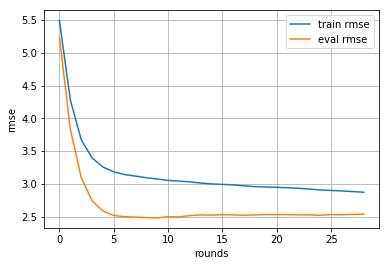

In [52]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

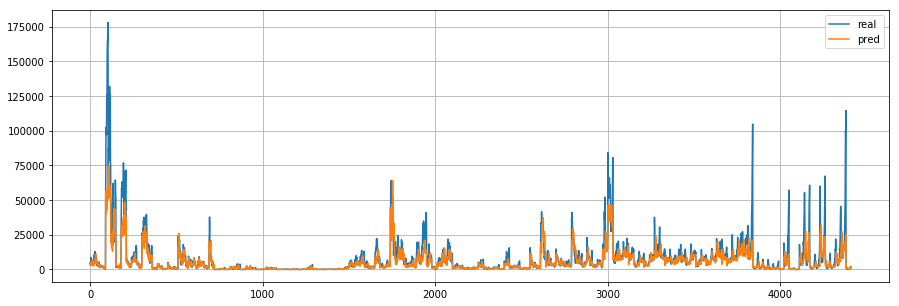

In [53]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Cost'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

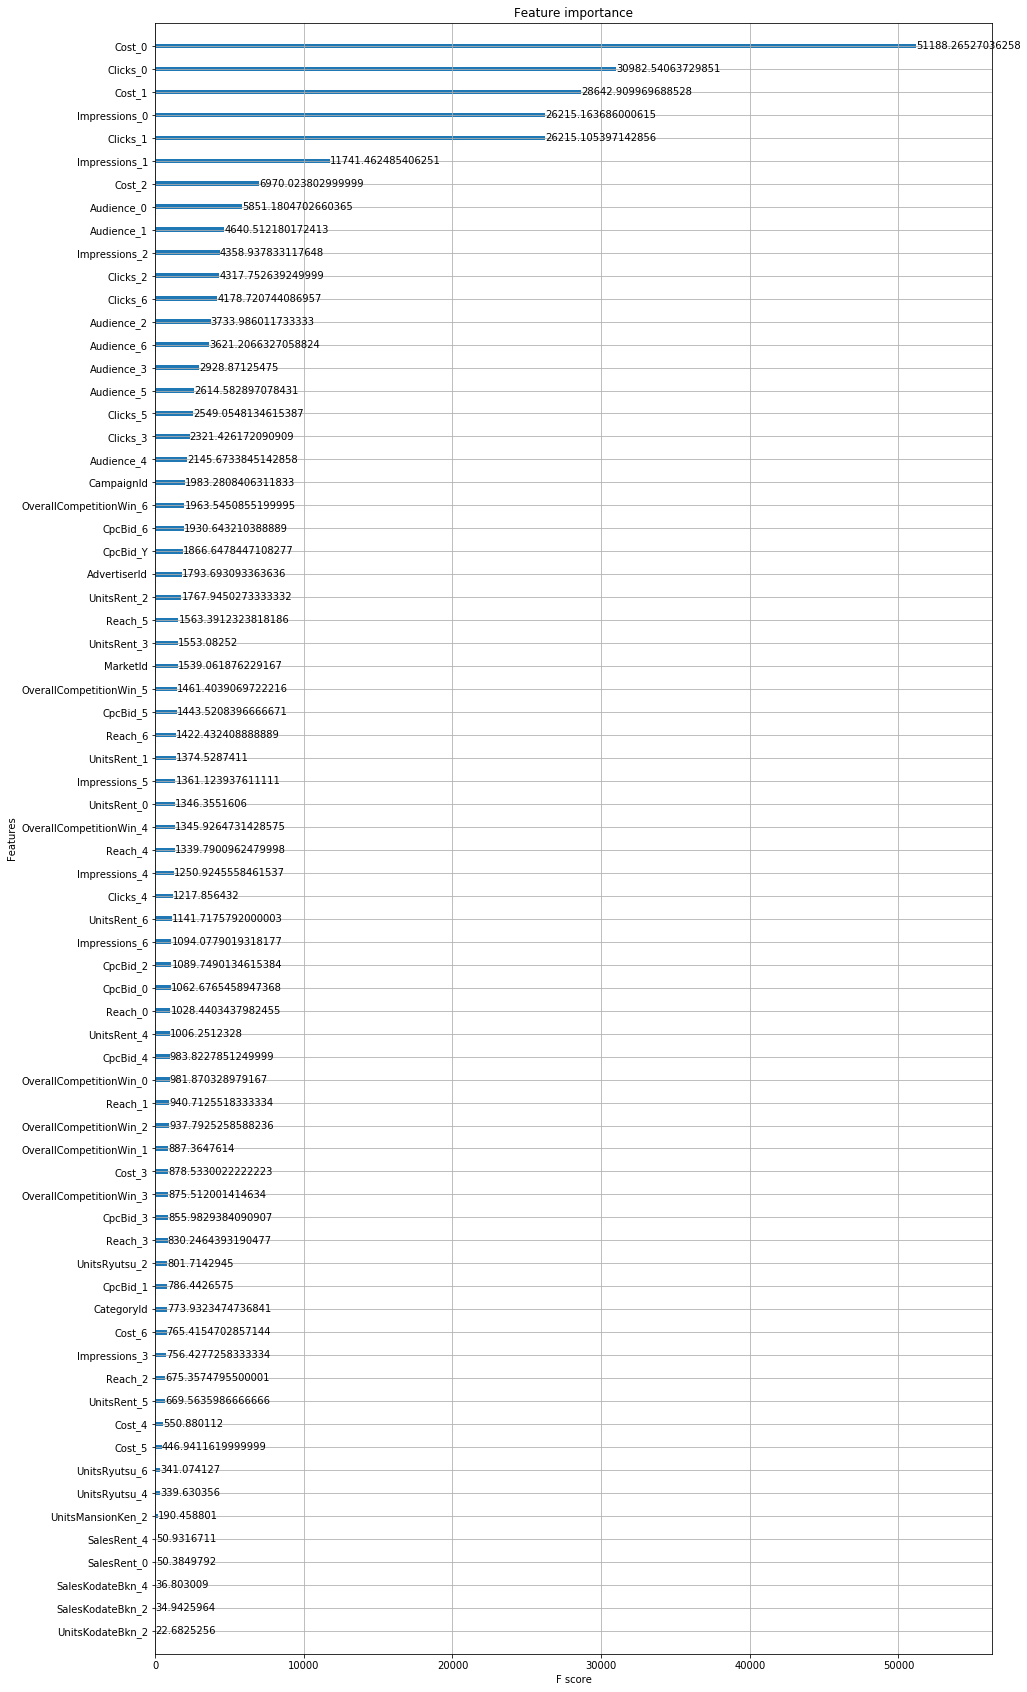

In [49]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [50]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['Cost_0',
 'Clicks_0',
 'Cost_1',
 'Impressions_0',
 'Clicks_1',
 'Impressions_1',
 'Cost_2',
 'Audience_0',
 'Audience_1',
 'Impressions_2',
 'Clicks_2',
 'Clicks_6',
 'Audience_2',
 'Audience_6',
 'Audience_3',
 'Audience_5',
 'Clicks_5',
 'Clicks_3',
 'Audience_4',
 'CampaignId',
 'OverallCompetitionWin_6',
 'CpcBid_6',
 'CpcBid_Y',
 'AdvertiserId',
 'UnitsRent_2',
 'Reach_5',
 'UnitsRent_3',
 'MarketId',
 'OverallCompetitionWin_5',
 'CpcBid_5',
 'Reach_6',
 'UnitsRent_1',
 'Impressions_5',
 'UnitsRent_0',
 'OverallCompetitionWin_4',
 'Reach_4',
 'Impressions_4',
 'Clicks_4',
 'UnitsRent_6',
 'Impressions_6',
 'CpcBid_2',
 'CpcBid_0',
 'Reach_0',
 'UnitsRent_4',
 'CpcBid_4',
 'OverallCompetitionWin_0',
 'Reach_1',
 'OverallCompetitionWin_2',
 'OverallCompetitionWin_1',
 'Cost_3',
 'OverallCompetitionWin_3',
 'CpcBid_3',
 'Reach_3',
 'UnitsRyutsu_2',
 'CpcBid_1',
 'CategoryId',
 'Cost_6',
 'Impressions_3',
 'Reach_2',
 'UnitsRent_5',
 'Cost_4',
 'Cost_5',
 'UnitsRyutsu_6',
 'UnitsRy